# <center> Implementação Computacional Teste:
## <center> Penalty-Based Nonlinear Solver for Optimal Reactive Power Dispatch With Discrete Controls
### <center> Edilaine Martins Soler, Eduardo N. Asada, Member, IEEE, and Geraldo R. M. da Costa, Member, IEEE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
from pandapower.networks import case14, case_ieee30, case118, case300, case4gs
from gekko import GEKKO
from pandapower.plotting.plotly import pf_res_plotly
import pandapower.plotting as pplot
import copy

# Dados do Sistema IEEE 14

In [2]:
from msc_rafael_pavan import inicializa_sep
from msc_rafael_pavan import matriz_condutancia
from msc_rafael_pavan import coleta_dados_vbus
from msc_rafael_pavan import coleta_dados_gen
from msc_rafael_pavan import func_objetivo
from msc_rafael_pavan import pen_tensao
from msc_rafael_pavan import pen_ger_reativo
from msc_rafael_pavan import coleta_dados_trafo
from msc_rafael_pavan import pen_trafo
from msc_rafael_pavan import coleta_dados_bshunt
from msc_rafael_pavan import converte_trafo
from msc_rafael_pavan import cria_alcateia
from msc_rafael_pavan import cria_enxame
from msc_rafael_pavan import pen_bshunt
from msc_rafael_pavan import fluxo_de_pot
from msc_rafael_pavan import fitness
from msc_rafael_pavan import validacao
from msc_rafael_pavan import validacao_q
from msc_rafael_pavan import fluxo_de_pot_q

from msc_rafael_pavan import otimizacao_gwo_continuo
from msc_rafael_pavan import otimizacao_pso_continuo
from msc_rafael_pavan import discreto_bshunt
from msc_rafael_pavan import discreto_tap
from msc_rafael_pavan import otimizacao_gwo_discreto
from msc_rafael_pavan import otimizacao_pso_discreto
from msc_rafael_pavan import ipm_ieee30
from msc_rafael_pavan import ipm_ieee14
from msc_rafael_pavan import cria_enxame_v


sep14 = case14()
sep118 = case118()
sep30 = case_ieee30()

v_init30 = inicializa_sep(sep30,algorithm='nr', relatorio=False)
v_init14 = inicializa_sep(sep14,algorithm='nr', relatorio=False)

v_init118 = inicializa_sep(sep118,algorithm='nr', relatorio=False)

v_init300 = inicializa_sep(sep14,algorithm='fdbx', relatorio=False)

sep14 = case300()

pp.runpp(sep14,tolerance_mva=1e-10, trafo_model='pi',algorithm='fdbx', voltages_angles=False)

In [3]:
def balanco_potencia_ativa_300(sep,pg_sgen,pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt,pshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(33333333)
    baux.append(33333331)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]  - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual] - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))

    return  pg[barra_atual] - pc[barra_atual] - soma + pg_sgen[barra_atual] - pshunt[barra_atual]*tensoes[barra_atual]**2

In [4]:
def balanco_potencia_reativa_300(sep,qg, qc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt, bshl, bsht,qshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(10101010101)
    baux.append(1000101010)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + -((-bkmt[posi]+bsht[posi]/2)/(tap[posi]**2))*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-((-bkmt[posi]+bsht[posi]/2)/(tap[posi]**2))*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + -(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    return  qg[barra_atual] - qc[barra_atual] - soma - qshunt[barra_atual]*tensoes[barra_atual]**2

In [5]:
def perdas_300(sep,gkml, gkmt, angulos, tensoes, tap, origem, destino, hv, lv):
    
    i = 0
    
    eq = []
 
    for bus in zip(origem,destino):
        
        
        perdas = gkml[i]*(tensoes[bus[0]]**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        i=i+1
        
        eq.append(perdas)
    
    j = 0
    

    
    for bus in zip(hv,lv):
        
        perdas = gkmt[j]*((tensoes[bus[0]]/tap[j])**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*(1/tap[j])*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        
        eq.append(perdas)
            
        j=j+1
        
    return perdas, eq
    

In [6]:
def automatiza_ipm_c_300(sep_, verbose=True, travado=False):
    
    sep14 = copy.copy(sep_)
    sep14.shunt = sep14.shunt.sort_index()
    sep14.res_line = sep14.res_line.sort_index()
    sep14.line = sep14.line.sort_index()
    origem = sep14.line[['from_bus']].values
    destino = sep14.line[['to_bus']].values
    ########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))
    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))
    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]

    sep14.trafo = sep14.trafo.sort_index()
    barras = sep14.trafo['hv_bus'].to_numpy()

    zkm = (sep14.trafo['vk_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())

    rkm = (sep14.trafo['vkr_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())

    a = 1

    zkm=zkm/10

    rkm=rkm/10

    xkm = np.sqrt(zkm**2-rkm**2)



    gkmt = (rkm*a/((a*rkm)**2+(a*xkm)**2))

    bkmt = (xkm*a/((a*rkm)**2+(a*xkm)**2))

    bsht = np.sqrt(np.power(sep14.trafo['i0_percent'].to_numpy()/100,2))

    bsht = bsht*99
    
    print(bsht)

        ########################################################################### Vetor de tap

    tap_pos = sep14.trafo[~pd.isnull(sep14.trafo['tap_pos'])]['tap_pos'].to_numpy(dtype=np.float64)

    tap_neutral = sep14.trafo[~pd.isnull(sep14.trafo['tap_neutral'])]['tap_neutral'].to_numpy(dtype=np.float64)

    tap_step_percent = sep14.trafo[~pd.isnull(sep14.trafo['tap_step_percent'])]['tap_step_percent'].to_numpy(dtype=np.float64)

    valor_percentual = (tap_pos-tap_neutral)*(tap_step_percent/100) + 1

    #     valor_percentual = np.resize(valor_percentual,(len(sep14.trafo)))


    to = np.zeros(len(sep14.trafo))
    td = np.zeros(len(sep14.trafo))

    for i in range(len(sep14.trafo)):

        if sep14.trafo['tap_side'].iloc[i] == None or sep14.trafo['tap_side'].iloc[i] == 'hv':

            to[i] = int(sep14.trafo['hv_bus'].iloc[i])


            td[i] = int(sep14.trafo['lv_bus'].iloc[i])

        if sep14.trafo['tap_side'].iloc[i] == 'lv':

            to[i] = int(sep14.trafo['lv_bus'].iloc[i])


            td[i] = int(sep14.trafo['hv_bus'].iloc[i])

    to = to.astype(int)
    td = td.astype(int)

    i = 0

    for i in range(len(valor_percentual)):

        if i < len(tap_pos):

            valor_percentual[i] = valor_percentual[i]

        else:

            valor_percentual[i] = 1


    tap = valor_percentual

    sep14.trafo['tap_pos'][~pd.isnull(sep14.trafo['tap_pos'])] = valor_percentual
    sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_pos'])] = 1
    tap = sep14.trafo['tap_pos'].values
    


    ########################################################################### Vetor de tensões das barras
    sep14.line = sep14.line.sort_index()

    sep14.res_bus = sep14.res_bus.sort_index()

    sep14.sgen = sep14.sgen.sort_index()

    v = sep14.res_bus['vm_pu'].to_numpy()
    Sbase=100
    ########################################################################### Vetor de ângulos das barras

    theta = np.radians(sep14.res_bus['va_degree'].to_numpy())

    ########################################################################### Vetor de potência ativa gerada
    sep14.gen = sep14.gen.sort_index()

    pg = np.zeros(len(sep14.bus))
    qg = np.zeros(len(sep14.bus))

    pg_sgen = np.zeros(len(sep14.bus))
    qg_sgen = np.zeros(len(sep14.bus))

    i = 0

    sep14.gen = sep14.gen.sort_index()

    sep14.res_gen = sep14.res_gen.sort_index()

    for bus in sep14.gen['bus'].to_numpy():

        pg[bus] = sep14.gen['p_mw'].to_numpy()[i]/Sbase

        i=i+1


    i=0

    for bus in sep14.sgen['bus'].to_numpy():

        pg_sgen[bus] = sep14.sgen['p_mw'].to_numpy()[i]/Sbase

        qg_sgen[bus] = sep14.sgen['q_mvar'].to_numpy()[i]/Sbase

        i = i+1

    if len(sep14.bus)==300:

        pg[256] = sep14.res_ext_grid['p_mw'].to_numpy()/100
        qg[256] = sep14.res_ext_grid['q_mvar'].to_numpy()/100


    pg_ls = sep14.ext_grid['max_p_mw'].to_numpy()/100

    pg_li = sep14.ext_grid['min_p_mw'].to_numpy()/100
    
    sep14.load = sep14.load.sort_index()
    pc = np.zeros(len(sep14.bus))

    i = 0

    sep14.load = sep14.load.sort_index()

    for bus in sep14.load['bus'].to_numpy():

        pc[bus] = sep14.load['p_mw'].to_numpy()[i]/Sbase

        i=i+1

    qc = np.zeros(len(sep14.bus))

    i = 0

    for bus in sep14.load['bus'].to_numpy():

        qc[bus] = sep14.load['q_mvar'].to_numpy()[i]/Sbase

        i=i+1


    ########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))

    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))

    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]

    qg = np.zeros(len(pg))


    if len(sep14.bus)==300:

        qg[256] = sep14.res_ext_grid['q_mvar'].values/100


    sepaux = sep14.gen['bus']

    for barra in sepaux:

        qg[barra]=sep14.res_gen[sep14.gen['bus']==barra]['q_mvar'].values/100


    barras = sep14.shunt['bus'].to_numpy()
    qshunt = np.zeros(np.shape(qg))
    pshunt = np.zeros(np.shape(pg))

    for barra in barras:

        qshunt[barra]=sep14.shunt[sep14.shunt['bus']==barra]['q_mvar'].values/100
        pshunt[barra]=sep14.shunt[sep14.shunt['bus']==barra]['p_mw'].values/100
    
    print(qshunt)
        
    hv=sep14.trafo['hv_bus'].values
    lv=sep14.trafo['lv_bus'].values
    
    
    bsht[81] = -bsht[81]

    bsht[99] = -bsht[99]

    bsht[90] = -bsht[90]

    bsht[91] = -bsht[91]

    bsht[102] = -bsht[102]

    bsht[103] = -bsht[103]
    
    tensoes = []
    angulos = []

    sep14.res_bus = sep14.res_bus.sort_index()


    v = sep14.res_bus['vm_pu'].to_numpy()


    theta = np.radians(sep14.res_bus['va_degree'].to_numpy())
    sep = GEKKO()

    for bus in range(len(sep14.bus)):

        tensoes.append(sep.Var(v[bus],0.94,1.06))
        angulos.append(sep.Var(theta[bus],0,2*np.pi))


    shunt = np.zeros(len(sep14.bus)).tolist()

    shunt[95]= sep.Var(qshunt[95],-4.5,0)
    shunt[98]= sep.Var(qshunt[98],-0.60,0)
    shunt[132]= sep.Var(qshunt[132],-0.45,0)
    shunt[142]= sep.Var(qshunt[142],0,4.5)
    shunt[144]= sep.Var(qshunt[144],0,4.5)
    shunt[151]= sep.Var(qshunt[151],-0.6,0)
    shunt[157]= sep.Var(qshunt[157],-0.6,0)
    shunt[168]= sep.Var(qshunt[168],0,4.5)
    shunt[209]= sep.Var(qshunt[209],0,4.5)
    shunt[216]= sep.Var(qshunt[216],0,4.5)
    shunt[218]= sep.Var(qshunt[218],0,4.5)
    shunt[226]= sep.Var(qshunt[226],-0.60,0)
    shunt[267]= sep.Var(qshunt[267],-0.15,0) #0.15
    shunt[282]= sep.Var(qshunt[282],-0.15,0) # 0.15
#     shunt[95]= sep.Var(qshunt[95],-3.25,3.25)
#     shunt[98]= sep.Var(qshunt[98],-3.25,3.25)
#     shunt[132]= sep.Var(qshunt[132],-3.25,3.25)
#     shunt[142]= sep.Var(qshunt[142],-3.25,3.25)
#     shunt[144]= sep.Var(qshunt[144],-3.25,3.25)
#     shunt[151]= sep.Var(qshunt[151],-3.25,3.25)
#     shunt[157]= sep.Var(qshunt[157],-3.25,3.25)
#     shunt[168]= sep.Var(qshunt[168],-3.25,3.25)
#     shunt[209]= sep.Var(qshunt[209],-3.25,3.25)
#     shunt[216]= sep.Var(qshunt[216],-3.25,3.25)
#     shunt[218]= sep.Var(qshunt[218],-3.25,3.25)
#     shunt[226]= sep.Var(qshunt[226],-3.25,3.25)
#     shunt[267]= sep.Var(qshunt[267],-3.25,3.25) #0.15
#     shunt[282]= sep.Var(qshunt[282],-3.25,3.25) # 0.15
    
    if travado==True:
        
        shunt=qshunt

    # shunt[4]= sep.sos1([0,0.4])
    # shunt[33]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
    # shunt[36]= sep.sos1([0,0.25])
    # shunt[43]= sep.sos1([0,-0.1])
    # shunt[44]= sep.sos1([0,-0.1])
    # shunt[45]= sep.sos1([0,-0.1])
    # shunt[47]= sep.sos1([0,-0.15])

    # shunt[73]= sep.sos1([0,-0.08,-0.12,-0.2])

    # shunt[78]= sep.sos1([0,-0.1,-0.2])

    # shunt[81]= sep.sos1([0,-0.1,-0.2])

    # shunt[82]= sep.sos1([0,-0.1,-0.2])

    # shunt[104]= sep.sos1([0,-0.1,-0.2])

    # shunt[106]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
    # shunt[109]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])



    sep14.trafo['tap_pos'][sep14.trafo['tap_pos']==np.nan] = 1

    tap = sep14.trafo['tap_pos'].to_numpy()

    taps = []

    for valor in tap:

        if valor !=1:

            taps.append(sep.Var(valor,0.9,1.1))
            #taps.append(sep.sos1([0.88,0.8875,0.895,0.9025,0.91,0.9175,0.925,0.9325,0.94,0.9475,0.955,0.9625,0.97,0.9775,0.985,0.9925,1.0,1.0075,1.015,1.0225,1.03,1.0375,1.045,1.0525,1.06,1.0675,1.075,1.0825,1.09,1.0975,1.105,1.1125,1.12]))

        else: 
            taps.append(1)


    if travado == True:
        
        taps = tap
        
    qgs = np.zeros(len(pg))

    qg = qgs.tolist()



    for bus in sep14.gen['bus'].to_numpy():

        qg[bus] = sep.Var((sep14.res_gen[sep14.gen['bus']==bus]['q_mvar'].to_numpy()/100)[0], (sep14.gen[sep14.gen['bus']==bus]['min_q_mvar'].to_numpy()/100)[0],(sep14.gen[sep14.gen['bus']==bus]['max_q_mvar'].to_numpy()/100)[0] )  


    qg[256] = sep.Var((sep14.res_ext_grid['q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['min_q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['max_q_mvar'].to_numpy()/100)[0])

    pgl=np.copy(pg)
    pgs = pgl.tolist()

    pgs[256] = sep.Var((sep14.res_ext_grid['p_mw'].to_numpy()/100)[0],(sep14.ext_grid['min_p_mw'].to_numpy()/100)[0],(sep14.ext_grid['max_p_mw'].to_numpy()/100)[0])


    for barra in range(0,len(sep14.bus)):


        sep.Equation(balanco_potencia_reativa_300(sep,qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)==0)

    for barra in range(0,len(sep14.bus)):


        sep.Equation(balanco_potencia_ativa_300(sep,pg_sgen,pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt,pshunt)==0)

    a, equations = perdas_300(sep,gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), to, td)

    sep.Obj(sep.sum(equations))

    sep.options.SOLVER = 3
    sep.options.MAX_ITER=10000

    sep.solver_options = ['tol 1e-4',\
                                   'constr_viol_tol 1e-4',\
                                'bound_push 1e-6',\
                                'bound_frac 1e-6']   

    sep.solve(disp=verbose)
    
    tensao = np.zeros(len(sep14.gen['bus'].to_numpy())+1)
    i=1
    tensao[0] = tensoes[256][0]

    for bus in sep14.gen['bus'].to_numpy():

        tensao[i] =  tensoes[bus][0]
        i=i+1

    trafo = []

    for i in range(len(taps)):


        if str(type(taps[i])) == "<class 'int'>":
            j=1
        else:

            trafo.append(taps[i])

    t = np.asarray(trafo).ravel()

    s = []
    i=0

    for bus in sep14.shunt['bus'].to_numpy():

        if travado == False:
            if str(type(shunt[bus])) == "<class 'float64'>" or str(type(shunt[bus])) == "<class 'float'>":
                j=1
                s.append(shunt[bus])
            else:
                s.append(shunt[bus][0])

 
        if travado == True:
            s.append(shunt[bus])




    sa = np.asarray(s).ravel()
    sa = sa*-1

    sep14.res_bus= sep14.res_bus.sort_index()

    thetas = np.zeros(len(angulos))

    voltages = np.zeros(len(angulos))

    pot_reativas = np.zeros(len(qg))


    for i in range(len(angulos)):

        thetas[i]=angulos[i][0]

        voltages[i]=tensoes[i][0]



    sep14.res_bus['vm_pu'] = 1

    sep14.res_bus['va_degree'] = 0


    sep14.res_ext_grid['p_mw'] = pgs[256][0]*100

    sep14.res_ext_grid['q_mvar'] = qg[256][0]*100

    sep14.shunt['q_mvar'] = sa*100

    gbest = np.concatenate((tensao,t,sa,np.array([0,0,0,0,0,0])),axis=0)


    sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_step_percent'])]=np.nan


    sep14.bus['max_vm_pu'] = 1.06

    sep14.bus['min_vm_pu'] = 0.94
    sep14.gen['min_vm_pu'] = 0.94

    sep14.gen['max_vm_pu'] = 1.06

    sep14.ext_grid['min_vm_pu'] = 0.94

    sep14.ext_grid['max_vm_pu'] = 1.06

    sep_atualizado = sep14.copy


    return gbest, sep14, tensao, t, sa

In [7]:
gbest,sep_atualizado, tensao, t, s = automatiza_ipm_c_300(sep14, verbose=True, travado=False)

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.25  0.185 0.321 0.33  0.335 0.171 0.    0.074
 0.076 0.    0.    0.    0.02  0.33  0.    0.186 0.    0.    1.364 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.087 0.    0.
 0.    0.    0.    0.    0.    0.    0.057 0.033 0.    0.    0.    0.
 0.    0.    0.    0.012 0.    0.    0.01  0.364 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.    

In [8]:
gbest

array([ 1.05264947e+00,  1.02519452e+00,  1.06000000e+00,  1.01883008e+00,
        1.06000000e+00,  9.99328726e-01,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.04159718e+00,  1.02381054e+00,  1.06000000e+00,
        1.06000000e+00,  1.05922532e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.05991384e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.04160272e+00,  1.06000000e+00,  1.06000000e+00,
        9.99476150e-01,  1.06000000e+00,  1.01486627e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02841016e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02519324e+00,  1.02846350e+00,
        1.00163248e+00,  9.91853962e-01,  1.06000000e+00,  1.01467086e+00,
        1.06000000e+00,  1.02818957e+00,  1.06000000e+00,  1.01295008e+00,
        1.04686834e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.05049986e+00,  1.06000000e+00,  1.02815527e+00,
        1.06000000e+00,  

[ 1.05264947e+00  1.02519452e+00  1.06000000e+00  1.01883008e+00
  1.06000000e+00  9.99328726e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04159718e+00  1.02381054e+00  1.06000000e+00
  1.06000000e+00  1.05922532e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05991384e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04160272e+00  1.06000000e+00  1.06000000e+00
  9.99476150e-01  1.06000000e+00  1.01486627e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02841016e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02519324e+00  1.02846350e+00
  1.00163248e+00  9.91853962e-01  1.06000000e+00  1.01467086e+00
  1.06000000e+00  1.02818957e+00  1.06000000e+00  1.01295008e+00
  1.04686834e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05049986e+00  1.06000000e+00  1.02812491e+00
  1.06000000e+00  1.06000000e+00  1.02002709e+00  1.02992804e+00
  1.02191059e+00  1.02174562e+00  1.06000000e+00  1.02610577e+00
  1.01743253e+00  1.06000

[ 1.05264947e+00  1.02519452e+00  1.06000000e+00  1.01883008e+00
  1.06000000e+00  9.99328726e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04159718e+00  1.02381054e+00  1.06000000e+00
  1.06000000e+00  1.05922532e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05991384e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04160272e+00  1.06000000e+00  1.06000000e+00
  9.99476150e-01  1.06000000e+00  1.01486627e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02841016e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02519324e+00  1.02846350e+00
  1.00163248e+00  9.91853962e-01  1.06000000e+00  1.01467086e+00
  1.06000000e+00  1.02818957e+00  1.06000000e+00  1.01295008e+00
  1.04686834e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05049986e+00  1.06000000e+00  1.02812491e+00
  1.06000000e+00  1.06000000e+00  1.02002709e+00  1.02992804e+00
  1.02191059e+00  1.02174562e+00  1.06000000e+00  1.02610577e+00
  1.01743253e+00  1.06000

[ 1.05264947e+00  1.02519452e+00  1.06000000e+00  1.01883008e+00
  1.06000000e+00  9.99328726e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04159718e+00  1.02381054e+00  1.06000000e+00
  1.06000000e+00  1.05922532e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05991384e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04160272e+00  1.06000000e+00  1.06000000e+00
  9.99476150e-01  1.06000000e+00  1.01486627e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02841016e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02519324e+00  1.02846350e+00
  1.00163248e+00  9.91853962e-01  1.06000000e+00  1.01467086e+00
  1.06000000e+00  1.02818957e+00  1.06000000e+00  1.01295008e+00
  1.04686834e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05049986e+00  1.06000000e+00  1.02812491e+00
  1.06000000e+00  1.06000000e+00  1.02002709e+00  1.02992804e+00
  1.02191059e+00  1.02174562e+00  1.06000000e+00  1.02610577e+00
  1.01743253e+00  1.06000

[ 1.05264947e+00  1.02519452e+00  1.06000000e+00  1.01883008e+00
  1.06000000e+00  9.99328726e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04159718e+00  1.02381054e+00  1.06000000e+00
  1.06000000e+00  1.05922532e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05991384e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04160272e+00  1.06000000e+00  1.06000000e+00
  9.99476150e-01  1.06000000e+00  1.01486627e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02841016e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02519324e+00  1.02846350e+00
  1.00163248e+00  9.91853962e-01  1.06000000e+00  1.01467086e+00
  1.06000000e+00  1.02818957e+00  1.06000000e+00  1.01295008e+00
  1.04686834e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05049986e+00  1.06000000e+00  1.02812491e+00
  1.06000000e+00  1.06000000e+00  1.02002709e+00  1.02992804e+00
  1.02191059e+00  1.02174562e+00  1.06000000e+00  1.02610577e+00
  1.01743253e+00  1.06000

[ 1.05086967e+00  1.02340160e+00  1.06000000e+00  1.01703716e+00
  1.06000000e+00  9.97535811e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03980427e+00  1.02201762e+00  1.06000000e+00
  1.06000000e+00  1.05895225e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03980981e+00  1.06000000e+00  1.06000000e+00
  9.97683235e-01  1.06000000e+00  1.01307336e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02661724e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02340033e+00  1.02667058e+00
  9.99839566e-01  9.90061047e-01  1.06000000e+00  1.01287795e+00
  1.06000000e+00  1.02639665e+00  1.06000000e+00  1.01115716e+00
  1.04507542e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04860096e+00  1.06000000e+00  1.02633200e+00
  1.06000000e+00  1.06000000e+00  1.01823418e+00  1.02813512e+00
  1.02011767e+00  1.01995271e+00  1.06000000e+00  1.02431285e+00
  1.01563961e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05118792e+00  1.02356404e+00  1.06000000e+00  1.01719960e+00
  1.06000000e+00  9.97698253e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03996671e+00  1.02218006e+00  1.06000000e+00
  1.06000000e+00  1.05898877e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.03997225e+00  1.06000000e+00  1.06000000e+00
  9.97845677e-01  1.06000000e+00  1.01323580e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02677968e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02356277e+00  1.02683303e+00
  1.00000201e+00  9.90223490e-01  1.06000000e+00  1.01304039e+00
  1.06000000e+00  1.02655910e+00  1.06000000e+00  1.01131961e+00
  1.04523787e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04879831e+00  1.06000000e+00  1.02649444e+00
  1.06000000e+00  1.06000000e+00  1.01839662e+00  1.02829756e+00
  1.02028012e+00  1.02011515e+00  1.06000000e+00  1.02447529e+00
  1.01580206e+00  1.06000

[ 1.05192507e+00  1.02438247e+00  1.06000000e+00  1.01801804e+00
  1.06000000e+00  9.98516684e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04078514e+00  1.02299849e+00  1.06000000e+00
  1.06000000e+00  1.05913996e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04079068e+00  1.06000000e+00  1.06000000e+00
  9.98664108e-01  1.06000000e+00  1.01405423e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02759811e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02438120e+00  1.02765146e+00
  1.00082044e+00  9.91041920e-01  1.06000000e+00  1.01385882e+00
  1.06000000e+00  1.02737753e+00  1.06000000e+00  1.01213804e+00
  1.04605630e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04957933e+00  1.06000000e+00  1.02731287e+00
  1.06000000e+00  1.06000000e+00  1.01921505e+00  1.02911599e+00
  1.02109855e+00  1.02093358e+00  1.06000000e+00  1.02529372e+00
  1.01662049e+00  1.06000

[ 1.05192507e+00  1.02438247e+00  1.06000000e+00  1.01801804e+00
  1.06000000e+00  9.98516684e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04078514e+00  1.02299849e+00  1.06000000e+00
  1.06000000e+00  1.05913996e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04079068e+00  1.06000000e+00  1.06000000e+00
  9.98664108e-01  1.06000000e+00  1.01405423e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02759811e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02438120e+00  1.02765146e+00
  1.00082044e+00  9.91041920e-01  1.06000000e+00  1.01385882e+00
  1.06000000e+00  1.02737753e+00  1.06000000e+00  1.01213804e+00
  1.04605630e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04957933e+00  1.06000000e+00  1.02731287e+00
  1.06000000e+00  1.06000000e+00  1.01921505e+00  1.02911599e+00
  1.02109855e+00  1.02093358e+00  1.06000000e+00  1.02529372e+00
  1.01662049e+00  1.06000

[ 1.05192507e+00  1.02438247e+00  1.06000000e+00  1.01801804e+00
  1.06000000e+00  9.98516684e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04078514e+00  1.02299849e+00  1.06000000e+00
  1.06000000e+00  1.05913996e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04079068e+00  1.06000000e+00  1.06000000e+00
  9.98664108e-01  1.06000000e+00  1.01405423e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02759811e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02438120e+00  1.02765146e+00
  1.00082044e+00  9.91041920e-01  1.06000000e+00  1.01385882e+00
  1.06000000e+00  1.02737753e+00  1.06000000e+00  1.01213804e+00
  1.04605630e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04957933e+00  1.06000000e+00  1.02731287e+00
  1.06000000e+00  1.06000000e+00  1.01921505e+00  1.02911599e+00
  1.02109855e+00  1.02093358e+00  1.06000000e+00  1.02529372e+00
  1.01662049e+00  1.06000

[ 1.05199115e+00  1.02435733e+00  1.06000000e+00  1.01799289e+00
  1.06000000e+00  9.98491544e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04076000e+00  1.02297335e+00  1.06000000e+00
  1.06000000e+00  1.05903457e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04076554e+00  1.06000000e+00  1.06000000e+00
  9.98638968e-01  1.06000000e+00  1.01402909e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02757297e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02435606e+00  1.02762632e+00
  1.00079530e+00  9.91016780e-01  1.06000000e+00  1.01383368e+00
  1.06000000e+00  1.02735239e+00  1.06000000e+00  1.01211290e+00
  1.04603116e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04991305e+00  1.06000000e+00  1.02728773e+00
  1.06000000e+00  1.06000000e+00  1.01918991e+00  1.02909085e+00
  1.02107341e+00  1.02090844e+00  1.06000000e+00  1.02526858e+00
  1.01659535e+00  1.06000

[ 1.05185823e+00  1.02403471e+00  1.06000000e+00  1.01799239e+00
  1.06000000e+00  9.98425928e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04073138e+00  1.02277356e+00  1.06000000e+00
  1.06000000e+00  1.05970897e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04069478e+00  1.06000000e+00  1.06000000e+00
  9.96810502e-01  1.06000000e+00  1.01388322e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02747109e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02409770e+00  1.02765460e+00
  1.00074794e+00  9.90346569e-01  1.06000000e+00  1.01353884e+00
  1.06000000e+00  1.02545687e+00  1.06000000e+00  1.01185737e+00
  1.04600537e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04968128e+00  1.06000000e+00  1.02693643e+00
  1.06000000e+00  1.06000000e+00  1.01939224e+00  1.02979375e+00
  1.02055136e+00  1.02089825e+00  1.06000000e+00  1.02522058e+00
  1.01792382e+00  1.06000

[ 1.05185823e+00  1.02403471e+00  1.06000000e+00  1.01799239e+00
  1.06000000e+00  9.98425928e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04073138e+00  1.02277356e+00  1.06000000e+00
  1.06000000e+00  1.05970897e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04069478e+00  1.06000000e+00  1.06000000e+00
  9.96810502e-01  1.06000000e+00  1.01388322e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02747109e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02409770e+00  1.02765460e+00
  1.00074794e+00  9.90346569e-01  1.06000000e+00  1.01353884e+00
  1.06000000e+00  1.02545687e+00  1.06000000e+00  1.01185737e+00
  1.04600537e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04968128e+00  1.06000000e+00  1.02693643e+00
  1.06000000e+00  1.06000000e+00  1.01939224e+00  1.02979375e+00
  1.02055136e+00  1.02089825e+00  1.06000000e+00  1.02522058e+00
  1.01792382e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

[ 1.05186343e+00  1.02489686e+00  1.06000000e+00  1.01885035e+00
  1.06000000e+00  9.99284741e-01  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04158971e+00  1.02363411e+00  1.06000000e+00
  1.06000000e+00  1.05944499e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.04155366e+00  1.06000000e+00  1.06000000e+00
  9.97940387e-01  1.06000000e+00  1.01474308e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02833037e+00  1.06000000e+00
  1.06000000e+00  1.06000000e+00  1.02495902e+00  1.02851219e+00
  9.99892024e-01  9.91213240e-01  1.06000000e+00  1.01440063e+00
  1.06000000e+00  1.02633947e+00  1.06000000e+00  1.01271866e+00
  1.04686367e+00  1.06000000e+00  1.06000000e+00  1.06000000e+00
  1.06000000e+00  1.05053204e+00  1.06000000e+00  1.02779896e+00
  1.06000000e+00  1.06000000e+00  1.01929770e+00  1.02936201e+00
  1.02082372e+00  1.02175634e+00  1.06000000e+00  1.02607916e+00
  1.01705031e+00  1.06000

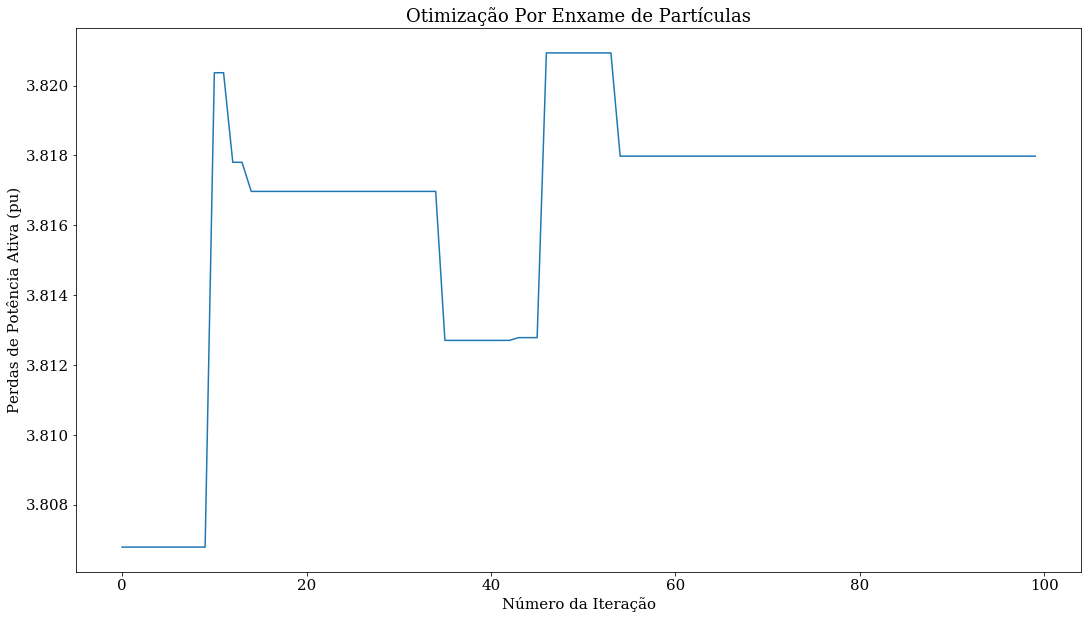

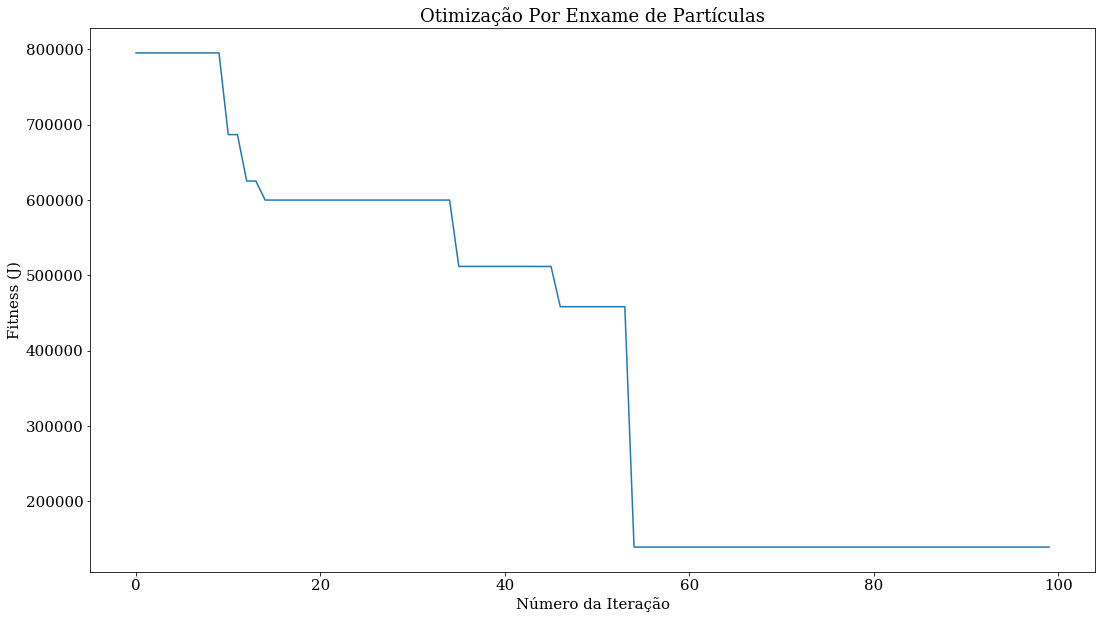

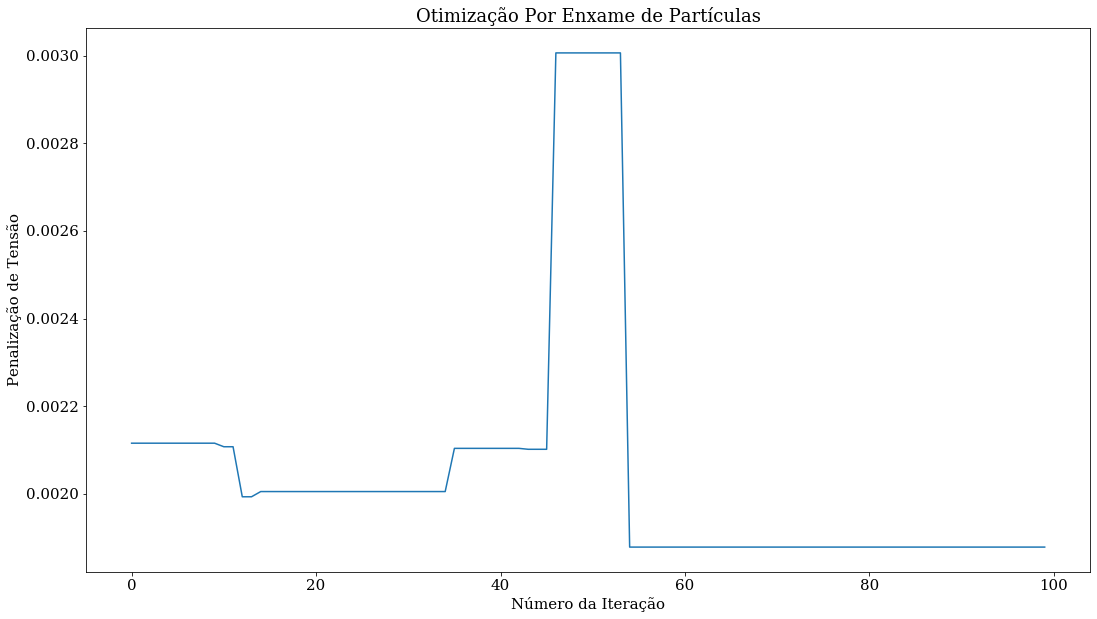

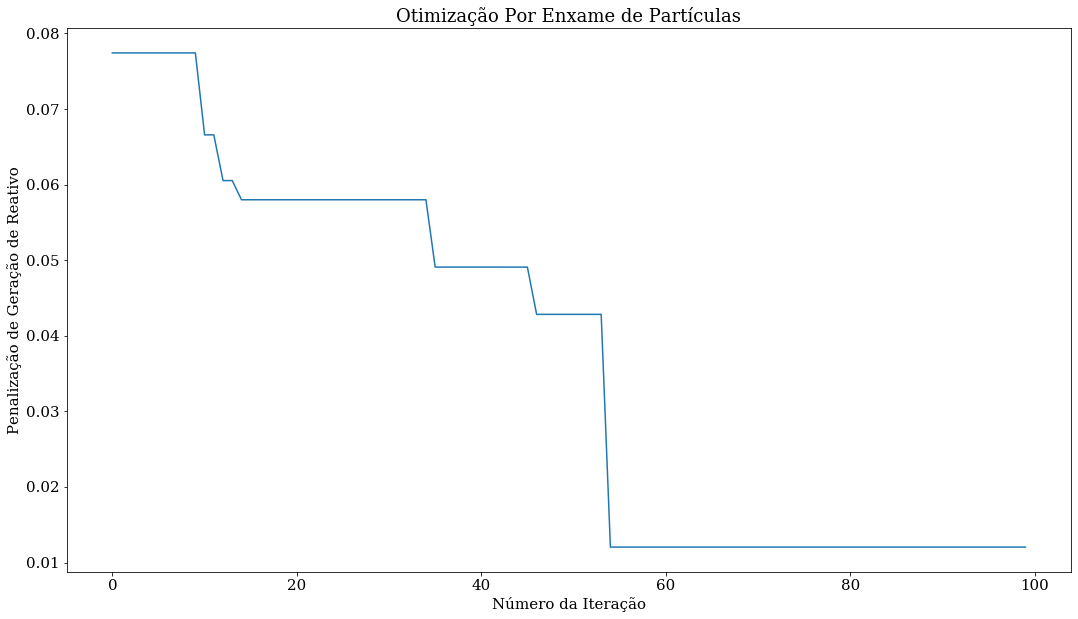

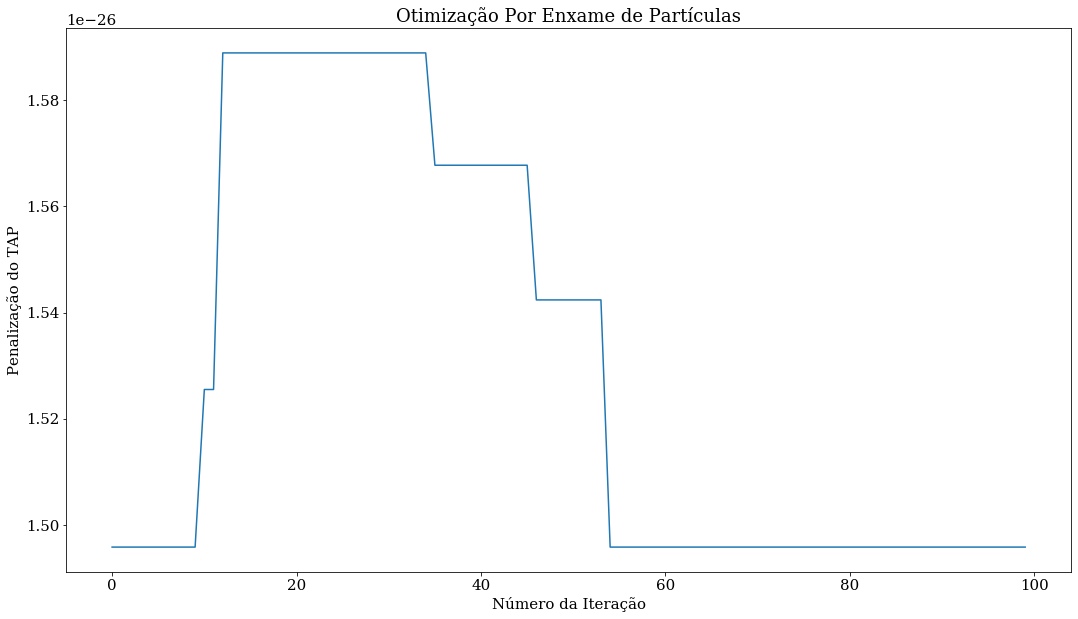

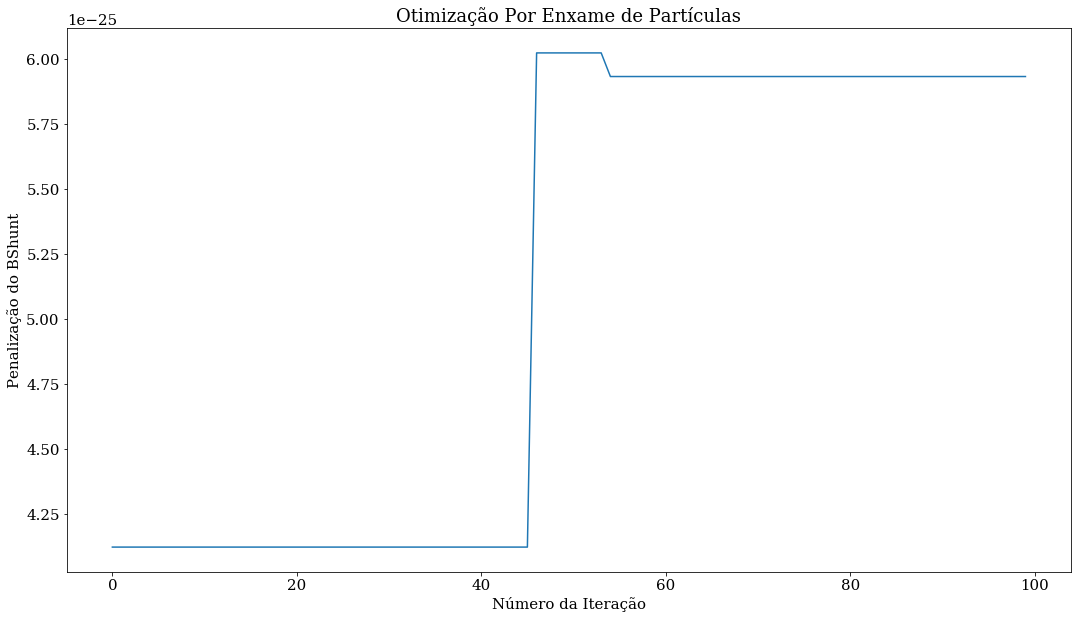

In [36]:
j,perdas,pen_v,pen_gq,pen_tap,pen_bsh,global_best, tempo = otimizacao_pso_discreto(sep_atualizado, zeta=1e7, psi=1e7, sigma=0, omega=0, max_iter=100, n_particles=10,c1=2.05,c2=2.05, v_amp=0.1, step=0.01, wmax=0.9,valor_inicial=gbest,relatorio=True,inicial=True)

In [37]:
gbest2=np.copy(global_best)

gbest2[69:62+69] = discreto_tap(gbest2,62,69,29,sep_atualizado)

gbest2[62+69:62+69+29] = discreto_bshunt(gbest2,62,69,29,sep_atualizado)

In [38]:
gbest[69:62+69]

array([0.97900335, 1.01734589, 0.97367866, 1.04716582, 0.92142331,
       1.03443744, 1.05152217, 1.04278197, 1.09999994, 1.04976429,
       0.99045073, 0.96841875, 0.96126003, 0.98071962, 1.01774019,
       0.94938014, 0.9363882 , 0.98237736, 0.96353915, 1.02495572,
       0.96580282, 0.99504542, 0.94089271, 1.07732368, 0.9861045 ,
       0.95539643, 0.9       , 0.91216267, 1.05914815, 1.04986473,
       0.9535551 , 0.99051803, 0.95872807, 0.98741974, 0.9467239 ,
       0.97767827, 0.96273762, 1.1       , 0.98754583, 0.95352039,
       1.01051549, 1.04308141, 1.03951666, 1.03870193, 0.9599196 ,
       1.06433654, 1.02138003, 1.06057715, 1.04101458, 1.04089623,
       0.95691615, 0.96103664, 0.98090897, 0.99298169, 1.01370527,
       0.93886819, 0.93552832, 0.9495846 , 0.9464523 , 0.9329041 ,
       0.94630101, 0.95527687])

In [39]:
gbest2[69:62+69]

array([0.98, 1.02, 0.98, 1.04, 0.92, 1.04, 1.06, 1.04, 1.1 , 1.04, 1.  ,
       0.96, 0.96, 0.98, 1.02, 0.94, 0.94, 0.98, 0.96, 1.02, 0.96, 1.  ,
       0.94, 1.08, 0.98, 0.96, 0.9 , 0.92, 1.06, 1.04, 0.96, 1.  , 0.96,
       0.98, 0.94, 0.98, 0.96, 1.1 , 0.98, 0.96, 1.02, 1.04, 1.04, 1.04,
       0.96, 1.06, 1.02, 1.06, 1.04, 1.04, 0.96, 0.96, 0.98, 1.  , 1.02,
       0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.96])

In [40]:
validacao(sep_atualizado,gbest2)


Perdas de Potência Ativa [PU]:

3.8179797161453326
 
Penalização de Violação de Tensão [PU]:

0.001878394817767293
 
Penalização de Violação de Geração de Reativo [PU]:

0.012043959529505339
 
Penalização de Violação de TAP Discreto [PU]:

1.4958663898344784e-26
 
Penalização de Violação de Bshunt Discreto [PU]:

5.933406309087487e-25
 


In [41]:
gbest3,sep_atualizado2, tensao, t, s = automatiza_ipm_c_300(sep_atualizado, verbose=True, travado=True)

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -4.5
  0.    0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 -0.15  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.    0.
  3.    0.    0.    0.    0.    0.    0.   -0.45  0.    0.    0.    0.
  0.   -0.45  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 -0. 

  48  2.6004693e+00 2.00e+00 3.43e+04  -1.3 1.21e+00    -  4.40e-01 6.65e-04h  1
  49  2.6007966e+00 2.00e+00 2.00e+07  -0.9 2.74e+00    -  1.89e-01 2.98e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.6008203e+00 2.00e+00 4.33e+10  -6.2 6.24e+00    -  3.73e-02 1.71e-05h  1
  51r 2.6008203e+00 2.00e+00 1.00e+03  -0.3 0.00e+00    -  0.00e+00 9.22e-08R  2
  52r 2.7749510e+00 8.99e-01 1.16e+03   1.1 1.60e+02    -  4.93e-03 2.38e-03f  1
  53  2.7850387e+00 8.90e-01 3.09e+01  -5.8 1.00e+00    -  3.25e-01 1.01e-02h  1
  54  2.7868876e+00 8.88e-01 1.53e+04  -1.1 1.08e+00    -  6.62e-01 1.71e-03h  1
  55  2.7880512e+00 8.87e-01 2.45e+06  -2.5 2.42e+00    -  2.82e-01 1.31e-03h  1
  56  2.7884019e+00 8.87e-01 1.19e+09  -1.1 2.97e+00    -  1.50e-01 3.06e-04h  1
  57r 2.7884019e+00 8.87e-01 1.00e+03  -0.6 0.00e+00    -  0.00e+00 2.96e-07R  5
  58r 2.9406548e+00 4.12e-01 1.89e+03   0.7 5.84e+01    -  2.63e-02 2.61e-03f  1
  59r 3.2058436e+00 3.48e-01

Exception:  @error: Solution Not Found


In [55]:
gbest3

array([ 1.09373012,  1.07094744,  1.09652222,  1.06627549,  1.09771335,
        1.04552547,  1.09988112,  1.09975828,  1.09992688,  1.08014348,
        1.06106071,  1.09994156,  1.09971255,  1.09528673,  1.09989491,
        1.09946945,  1.09994806,  1.0985586 ,  1.09995463,  1.0998359 ,
        1.09948102,  1.0632704 ,  1.09981575,  1.09902197,  1.04464934,
        1.0999591 ,  1.05775238,  1.09977015,  1.09995572,  1.09994902,
        1.06353148,  1.09998562,  1.09584865,  1.09988172,  1.06172735,
        1.06307242,  1.03143997,  1.02833273,  1.09889004,  1.04603172,
        1.09942969,  1.06505919,  1.09829022,  1.04344839,  1.08718207,
        1.09658493,  1.09727208,  1.09997077,  1.09909285,  1.09190493,
        1.09995495,  1.06816488,  1.09992762,  1.09990693,  1.0654361 ,
        1.07369915,  1.05186986,  1.04410711,  1.09990244,  1.05951064,
        1.03338325,  1.09997988,  1.09983499,  1.0883233 ,  1.08589415,
        1.08155882,  1.07782003,  1.09918299,  1.08888253,  0.98

In [83]:
def perdas_numpy(gkml, gkmt, angulos, tensoes, tap, origem, destino, hv, lv):
    
    i = 0
    perdas = 0
    
 
    for bus in zip(origem,destino):
        
        
        perdas = perdas + gkml[i]*(tensoes[bus[0]]**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*np.cos(angulos[bus[0]]-angulos[bus[1]]))
        i=i+1
        
    
    j = 0
    
    val=[]
    for bus in zip(hv,lv):
        
        perdas = perdas + gkmt[j]*((tensoes[bus[0]]/tap[j])**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*(1/tap[j])*np.cos(angulos[bus[0]]-angulos[bus[1]]))
        val.append(perdas)
            
        j=j+1
        
    return perdas
    

In [84]:
perdas_numpy(gkm,gkmt,theta,v,tap,origem.ravel(),destino.ravel(),to,td)


# sep14.res_line['pl_mw'].sum()+ sep14.res_trafo['pl_mw'].sum()

4.083155817863646

In [85]:
sep14.res_trafo.sort_index()['pl_mw'].sum() + sep14.res_line.sort_index()['pl_mw'].sum()

408.3155817863783

In [86]:
gkmt[0]*((v[30]/tap[0])**2+v[265]**2 - 2*v[30]*v[265]*(1/tap[0])*np.cos(theta[30]-theta[265]))

3.7607512023984126e-05

In [87]:
def balanco_potencia_ativa_numpy(pg_sgen, pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, taps, bkmt,gkmt,pshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(33333333)
    baux.append(33333331)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)

        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]  - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual] - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
#         soma = soma + (gkmt[posi]*tensoes[bd]*tensoes[bd]  - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[bd]-angulos[barra_atual])-bkmt[posi]*np.sin(angulos[bd]-angulos[barra_atual])))
    
#         fluxos.append(gkmt[posi]*tensoes[bd]*tensoes[bd] - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[bd]-angulos[barra_atual])-bkmt[posi]*np.sin(angulos[bd]-angulos[barra_atual])))

    return  pg[barra_atual] + pg_sgen[barra_atual] - pc[barra_atual] - np.sum(fluxos)-pshunt[barra_atual]*tensoes[barra_atual]**2, fluxos

In [88]:
vector = []

for bar in range(0,len(sep14.bus)):

    val,_ = balanco_potencia_ativa_numpy(pg_sgen,pg, pc, origem.ravel(), destino.ravel(), bar, gkm, bkm, v, theta, to.astype(int), td.astype(int), tap, bkmt,gkmt,pshunt)

    vector.append(val)
    

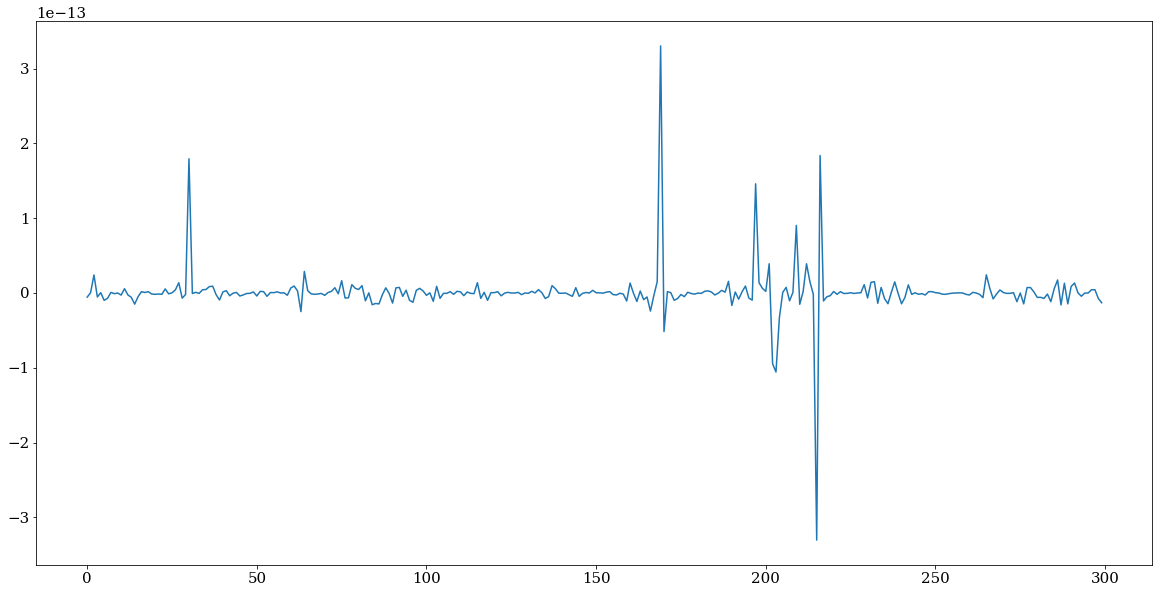

In [89]:
plt.plot(vector)

In [90]:
a,j = balanco_potencia_ativa_numpy(pg_sgen, pg, pc, origem.ravel(), destino.ravel(), 133, gkm, bkm, v, theta, to.astype(int), td.astype(int), tap, bkmt,gkmt,pshunt)

print(a)

print(j)

print(np.sum(j))

4.440892098500626e-15
[-0.7124745156597139, 1.0284365816505845, -2.315962065990875]
-2.0000000000000044


In [91]:
sep14.line[sep14.line['from_bus']==107]

,c_nf_per_km,df,from_bus,g_us_per_km,in_service,length_km,max_i_ka,max_loading_percent,name,parallel,r_ohm_per_km,std_type,to_bus,type,x_ohm_per_km
164,611.748679,1.0,107,0.0,True,1.0,24.851164,100.0,None,1,4.0204,None,108,ol,39.7808
165,150.430003,1.0,107,0.0,True,1.0,24.851164,100.0,None,1,1.1109,None,111,ol,9.8394


In [92]:
td[to==107]

# 29 trafo

sep14.res_line.sort_index().iloc[165,:]

p_from_mw          99.454410
q_from_mvar        -7.353956
p_to_mw           -99.247150
q_to_mvar           6.175199
pl_mw               0.207260
ql_mvar            -1.178758
i_from_ka           0.249629
i_to_ka             0.249116
i_ka                0.249629
vm_from_pu          1.002825
va_from_degree     -4.377138
vm_to_pu            1.001998
va_to_degree       -5.438992
loading_percent     1.004495
Name: 165, dtype: float64

In [114]:
taps

[[1.0082],
 [0.9668],
 [0.9796],
 [1.0435],
 [0.9391],
 [1.0435],
 [1.0435],
 [1.0435],
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 [0.9583],
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 [0.947],
 [0.956],
 [0.971],
 [0.948],
 [0.959],
 [1.046],
 [0.985],
 [0.9561],
 [0.971],
 [0.952],
 [0.943],
 [1.01],
 [1.008],
 1,
 [0.975],
 [1.017],
 1,
 1,
 1,
 1,
 [1.015],
 [0.967],
 [1.01],
 [1.05],
 1,
 [1.0522],
 [1.0522],
 [1.05],
 [0.975],
 1,
 [1.035],
 [0.9565],
 1,
 [1.05],
 [1.073],
 [1.05],
 [1.0506],
 [0.975],
 [0.98],
 [0.956],
 [1.05],
 [1.03],
 [1.03],
 [0.985],
 1,
 [1.03],
 [1.01],
 [1.05],
 [1.03],
 1,
 [0.97],
 1,
 [1.02],
 [1.07],
 [1.02],
 [1.0223],
 [0.9284],
 1,
 1,
 1,
 [0.95],
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 [0.942],
 [0.965],
 [0.95],
 [0.942],
 [0.942],
 [0.9565]]

In [94]:
def balanco_potencia_reativa_numpy(qg_sgen,qg, qc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, taps, bkmt,gkmt, bshl, bsht,qshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(10101010101)
    baux.append(1000101010)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
            print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
        print(bd,'vai linha')
        print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
            print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
        print(bd,'volta linha')
        print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
        print(bd,'vai trafo')
        print(posi)
        
        soma = soma + -(((-bkmt[posi])+bsht[posi]/2)/(tap[posi]**2))*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(((-bkmt[posi])+bsht[posi]/2)/(tap[posi]**2))*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
        print(posi)

        
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
        
        print(bd,'volta trafo')
        print(posi)

        
        
        soma = soma + -(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    return  qg[barra_atual] - qc[barra_atual] - soma - qshunt[barra_atual]*tensoes[barra_atual]**2 + qg_sgen[barra_atual], fluxos

In [95]:
-(-bkmt[90]+bsht[90]/2)*v[115]**2+v[141]*(1/tap[90])*v[115]*(-bkmt[90]*np.cos(theta[115]-theta[141])-gkmt[90]*np.sin(theta[115]-theta[141]))

-0.28612780710709984

In [96]:
-(((-bkmt[90])+bsht[90]/2)/(tap[90]**2))*v[141]**2 +v[141]*(1/tap[90])*v[115]*(-bkmt[90]*np.cos(np.round(theta[141]-theta[115],15))-gkmt[90]*np.sin(np.round(theta[141]-theta[115],15)))

0.39622044723608596

In [98]:
sep14.trafo[sep14.trafo['tap_pos']==1]['tap_pos']=np.nan
ze=[]


for bus in range(len(sep14.bus)):

  
    
    z,t = balanco_potencia_reativa_numpy(qg_sgen, qg, qc, origem.ravel(), destino.ravel(), bus, gkm, bkm, v, theta, to, td, tap, bkmt,gkmt, bsh, bsht,qshunt)
    ze.append(z)


4 vai linha
12
246 vai trafo
115
115
2 volta trafo
52
5 vai linha
13
7 vai linha
14
247 vai trafo
109
109
2 volta trafo
53
6 vai linha
15
17 vai linha
16
128 vai linha
17
0 vai trafo
52
52
1 vai trafo
53
53
3 vai trafo
54
54
248 vai trafo
110
110
15 vai linha
18
2 volta trafo
54
8 vai linha
19
0 volta linha
12
6 volta trafo
55
1 volta linha
13
6 volta trafo
56
11 vai linha
20
109 vai linha
21
2 volta linha
15
4 vai trafo
55
55
5 vai trafo
56
56
10 vai linha
22
13 vai linha
23
1 volta linha
14
10 vai linha
24
4 volta linha
19
10 vai trafo
57
57
11 volta trafo
58
12 vai linha
25
7 volta linha
22
8 volta linha
24
249 vai trafo
117
117
9 volta trafo
57
19 vai linha
26
6 volta linha
20
9 vai trafo
58
58
250 vai trafo
121
121
18 vai linha
27
10 volta linha
25
14 vai linha
28
7 volta linha
23
30 vai linha
29
73 vai linha
30
74 vai linha
31
13 volta linha
28
16 vai trafo
59
59
15 volta trafo
60
35 vai linha
32
3 volta linha
18
14 vai trafo
60
60
14 volta trafo
59
251 volta trafo
122
19 vai lin

In [99]:
# bkmt[91] = 43.22459099

ze = np.asarray(ze).ravel()


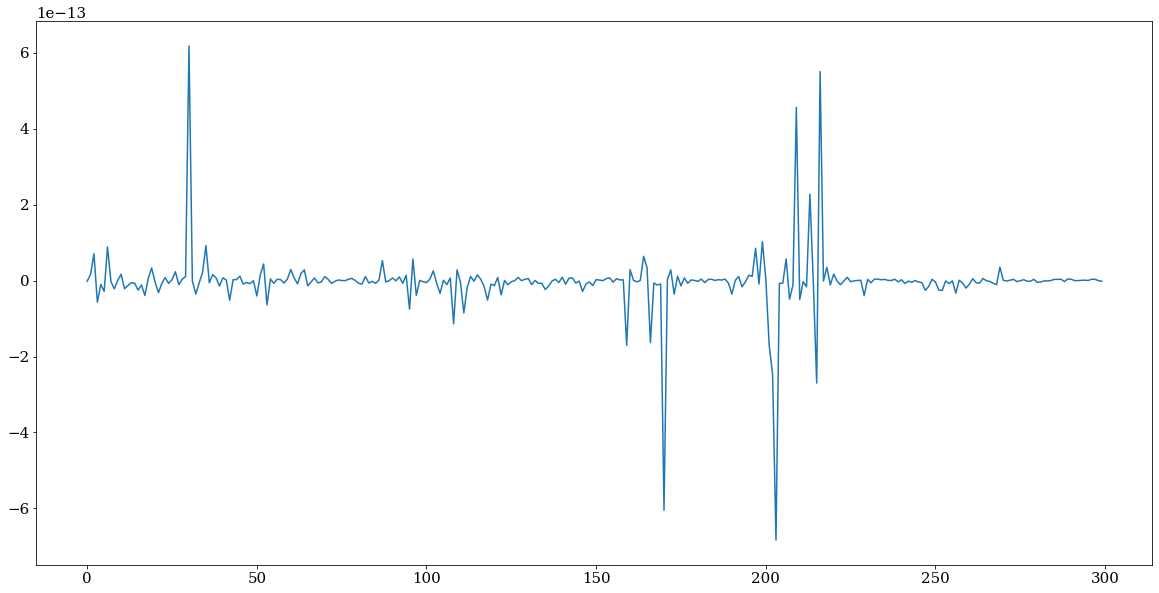

In [100]:
plt.plot(ze)

In [101]:

z,t = balanco_potencia_reativa_numpy(qg_sgen, qg, qc, origem.ravel(), destino.ravel(), 141, gkm, bkm, v, theta, to, td, tap, bkmt,gkmt, bsh, bsht,qshunt)

print(z)

print(t)

142 vai linha
206
115 vai trafo
90
90
-9.322403959899361e-15
[-0.4645385118889287, 0.460538511888938]


In [102]:
sep14.line[sep14.line['to_bus']==201]
sep14.trafo[sep14.trafo['hv_bus']==142].iloc[0,:]

sep14.res_trafo.sort_index().iloc[91,:]


p_hv_mw            232.073333
q_hv_mvar           49.676249
p_lv_mw           -231.596207
q_lv_mvar          -33.973223
pl_mw                0.477127
ql_mvar             15.703026
i_hv_ka              0.605491
i_lv_ka              0.577346
vm_hv_pu             0.983914
va_hv_degree         9.684462
vm_lv_pu             1.017724
va_lv_degree         6.774358
loading_percent      2.436471
Name: 91, dtype: float64

In [103]:
print(np.degrees(theta[115]))
print(sep14.res_trafo.sort_index().iloc[90,:]['va_lv_degree'])

-1.431507391291296
-1.431507391291296


In [104]:
sep14.res_bus.iloc[115]


vm_pu          1.047088
va_degree     -1.431507
p_mw         273.600000
q_mvar        99.800000
Name: 115, dtype: float64

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,95,None,-325.00,0.00,115.0,1,1,True
1,98,None,-55.00,0.00,115.0,1,1,True
2,132,None,-34.50,0.00,115.0,1,1,True
3,142,None,212.00,0.00,230.0,1,1,True
4,144,None,103.00,0.00,230.0,1,1,True
5,151,None,-53.00,0.00,115.0,1,1,True
6,157,None,-45.00,0.00,115.0,1,1,True
7,168,None,150.00,0.00,345.0,1,1,True
8,209,None,300.00,0.00,345.0,1,1,True
9,216,None,150.00,0.00,138.0,1,1,True


[1.0082,
 0.9668,
 0.9796,
 1.0435,
 0.9391,
 1.0435,
 1.0435,
 1.0435,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9583,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.947,
 0.956,
 0.971,
 0.948,
 0.959,
 1.046,
 0.985,
 0.9561,
 0.971,
 0.952,
 0.943,
 1.01,
 1.008,
 1,
 0.975,
 1.017,
 1,
 1,
 1,
 1,
 1.015,
 0.967,
 1.01,
 1.05,
 1,
 1.0522,
 1.0522,
 1.05,
 0.975,
 1,
 1.035,
 0.9565,
 1,
 1.05,
 1.073,
 1.05,
 1.0506,
 0.975,
 0.98,
 0.956,
 1.05,
 1.03,
 1.03,
 0.985,
 1,
 1.03,
 1.01,
 1.05,
 1.03,
 1,
 0.97,
 1,
 1.02,
 1.07,
 1.02,
 1.0223,
 0.9284,
 1,
 1,
 1,
 0.95,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.942,
 0.965,
 0.95,
 0.942,
 0.942,
 0.9565]

apm 191.254.77.203_gk_model4 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :         1158
   Intermediates:            0
   Connections  :          412
   Equations    :         1012
   Residuals    :         1012
 
 Number of state variables:           1158
 Number of total equations: -         1012
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            146
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program co

In [56]:



#t =np.array([taps[0],taps[1],taps[2],taps[3],taps[4],taps[5],taps[6],taps[8],taps[10]])

In [57]:
str(type(shunt[95]))

"<class 'gekko.gk_variable.GKVariable'>"

In [58]:
sa = shunt

0
1
2
3
4
5
5
5
5
5
5
5
5
6
7
7
7
7
7
7
7
7
7
8
9
10
11
12
13


In [60]:
sa.ravel()

array([ 3.45156279e+00,  2.79839497e-05, -3.02058816e-03,  5.89998335e-01,
        1.49998454e-01, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        9.10161488e-02,  6.31991001e-03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -8.35415268e-01, -3.73802792e-01,
        5.89999413e-01,  5.89999629e-01, -1.80081309e+00, -4.49999447e+00,
       -6.06807372e-06])

In [62]:




# #gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)]*-1

In [63]:

validacao(sep14,gbest)


Perdas de Potência Ativa [PU]:

3.807408905366324
 
Penalização de Violação de Tensão [PU]:

0.0015242451549169942
 
Penalização de Violação de Geração de Reativo [PU]:

12.111977107019097
 
Penalização de Violação de TAP Discreto [PU]:

24.57585866859419
 
Penalização de Violação de Bshunt Discreto [PU]:

1.0
 


In [64]:


gbest=np.copy(gbest)

gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep14)

gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep14)

validacao(sep14,gbest)

Perdas de Potência Ativa [PU]:

3.8565700437327086
 
Penalização de Violação de Tensão [PU]:

0.0022324632673809343
 
Penalização de Violação de Geração de Reativo [PU]:

38.130819578821544
 
Penalização de Violação de TAP Discreto [PU]:

34.499999999999964
 
Penalização de Violação de Bshunt Discreto [PU]:

3.224835797309688e-25
 


[1.05264982e+00 1.02521110e+00 1.05999776e+00 1.01883913e+00
 1.05999991e+00 9.99320980e-01 1.05999998e+00 1.05999994e+00
 1.05999999e+00 1.04159620e+00 1.02380992e+00 1.05999984e+00
 1.05999986e+00 1.05924252e+00 1.05999997e+00 1.05999987e+00
 1.06000000e+00 1.05986984e+00 1.05999998e+00 1.05999996e+00
 1.05999999e+00 1.04160146e+00 1.05999956e+00 1.05999956e+00
 9.99474706e-01 1.06000000e+00 1.01473388e+00 1.05999991e+00
 1.05999999e+00 1.05999999e+00 1.02841933e+00 1.06000000e+00
 1.05999993e+00 1.05999997e+00 1.02521273e+00 1.02847500e+00
 1.00164764e+00 9.91862581e-01 1.05999977e+00 1.01468323e+00
 1.05999986e+00 1.02820879e+00 1.05999983e+00 1.01296403e+00
 1.04671456e+00 1.05999857e+00 1.05999997e+00 1.05999999e+00
 1.05999998e+00 1.05050777e+00 1.05999998e+00 1.02102151e+00
 1.05999998e+00 1.05999996e+00 1.01469826e+00 1.02278562e+00
 1.01676950e+00 1.01637014e+00 1.05999998e+00 1.01987557e+00
 1.01320188e+00 1.06000000e+00 1.05999991e+00 1.05086124e+00
 1.05272455e+00 1.059999

[1.04720227e+00 1.01976354e+00 1.06000000e+00 1.01339158e+00
 1.06000000e+00 9.93873426e-01 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.03614864e+00 1.01836237e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.03615391e+00 1.06000000e+00 1.06000000e+00
 9.94027152e-01 1.06000000e+00 1.00928633e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.02297178e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.01976517e+00 1.02302745e+00
 9.96200089e-01 9.86415027e-01 1.06000000e+00 1.00923568e+00
 1.06000000e+00 1.02276124e+00 1.06000000e+00 1.00751648e+00
 1.04126700e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.04506022e+00 1.06000000e+00 1.01557396e+00
 1.06000000e+00 1.06000000e+00 1.00925071e+00 1.01733807e+00
 1.01132195e+00 1.01092258e+00 1.06000000e+00 1.01442802e+00
 1.00775433e+00 1.06000000e+00 1.06000000e+00 1.04541369e+00
 1.04727700e+00 1.060000

[1.04130503e+00 1.01386630e+00 1.06000000e+00 1.00749434e+00
 1.06000000e+00 9.87976189e-01 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.03025141e+00 1.01246513e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.03025667e+00 1.06000000e+00 1.06000000e+00
 9.88129915e-01 1.06000000e+00 1.00338909e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.01707454e+00 1.06000000e+00
 1.06000000e+00 1.06000000e+00 1.01386794e+00 1.01713021e+00
 9.90302852e-01 9.80517790e-01 1.06000000e+00 1.00333844e+00
 1.06000000e+00 1.01686400e+00 1.06000000e+00 1.00161924e+00
 1.03536977e+00 1.06000000e+00 1.06000000e+00 1.06000000e+00
 1.06000000e+00 1.03916298e+00 1.06000000e+00 1.00967672e+00
 1.06000000e+00 1.06000000e+00 1.00335347e+00 1.01144083e+00
 1.00542471e+00 1.00502535e+00 1.06000000e+00 1.00853078e+00
 1.00185709e+00 1.06000000e+00 1.06000000e+00 1.03951645e+00
 1.04137976e+00 1.060000

[ 1.00767152e+00  9.92280088e-01  1.05010554e+00  1.02507184e+00
  1.06000000e+00  9.74654379e-01  1.03847970e+00  9.94143617e-01
  9.93150649e-01  1.01336118e+00  1.02798881e+00  1.03610606e+00
  1.02492734e+00  1.06000000e+00  9.97519700e-01  1.02200334e+00
  1.02636330e+00  9.99126572e-01  1.03030762e+00  1.02494299e+00
  1.02379330e+00  1.01485367e+00  1.04826750e+00  1.00740787e+00
  9.55735481e-01  1.02788881e+00  9.89289148e-01  1.02287825e+00
  1.03420535e+00  1.02763467e+00  1.04957349e+00  9.91105317e-01
  1.02495649e+00  1.03218188e+00  1.00149358e+00  9.95521151e-01
  9.75029021e-01  9.85645373e-01  1.02716606e+00  1.02374360e+00
  1.03775190e+00  9.99146542e-01  1.05072167e+00  1.03497323e+00
  1.01382140e+00  1.02212095e+00  1.01068516e+00  1.03585210e+00
  1.03363747e+00  1.01848217e+00  1.02578838e+00  9.92091138e-01
  1.02923165e+00  1.04895849e+00  9.84830005e-01  9.89094316e-01
  1.04019610e+00  1.01570973e+00  1.02231712e+00  1.03717013e+00
  1.00985588e+00  1.03504

[ 1.00429681e+00  9.89377557e-01  1.04580860e+00  1.00278464e+00
  1.03073634e+00  9.70210142e-01  1.03318081e+00  1.02810450e+00
  1.01846003e+00  1.00805977e+00  1.01088014e+00  1.00961878e+00
  1.02108059e+00  1.01216502e+00  1.03483093e+00  1.01663653e+00
  1.03109719e+00  1.01701597e+00  1.03269727e+00  1.02956381e+00
  1.01895110e+00  1.01933216e+00  1.05086947e+00  1.01280844e+00
  1.00069401e+00  1.04209829e+00  9.91694437e-01  1.01853461e+00
  1.00941942e+00  1.02750322e+00  1.03103264e+00  1.01846003e+00
  1.02114973e+00  1.04379528e+00  9.96695440e-01  1.00281579e+00
  9.71094614e-01  9.88728497e-01  1.03571625e+00  1.00239288e+00
  1.04223029e+00  1.00549091e+00  1.02966709e+00  1.02269904e+00
  1.03015575e+00  1.01992796e+00  1.00680241e+00  1.04453118e+00
  1.01907691e+00  1.02752138e+00  1.02835848e+00  9.87281035e-01
  1.02654056e+00  1.04397736e+00  9.81465904e-01  9.96299259e-01
  1.00026252e+00  1.01380893e+00  1.02237139e+00  9.99316488e-01
  9.85765166e-01  1.02295

[ 1.00006775e+00  9.85148506e-01  1.04468612e+00  1.00701369e+00
  1.03496539e+00  9.65981092e-01  1.02924400e+00  1.02387545e+00
  1.01423098e+00  1.00411579e+00  1.01510919e+00  1.01384783e+00
  1.01685154e+00  1.01639407e+00  1.03060188e+00  1.01240748e+00
  1.03346328e+00  1.01278692e+00  1.02846822e+00  1.03157073e+00
  1.01472205e+00  1.02093395e+00  1.05509852e+00  1.01703462e+00
  9.96464960e-01  1.03786923e+00  9.87465387e-01  1.01731661e+00
  1.01364847e+00  1.02327417e+00  1.03526169e+00  1.01423098e+00
  1.01692068e+00  1.03956623e+00  9.98359260e-01  9.95839185e-01
  9.71041364e-01  9.91710265e-01  1.02768813e+00  1.00662193e+00
  1.04383181e+00  1.00097891e+00  1.03389614e+00  1.02692810e+00
  1.02478702e+00  1.01569891e+00  1.01103146e+00  1.03658218e+00
  1.02330596e+00  1.02114874e+00  1.03258753e+00  9.84735411e-01
  1.02571292e+00  1.04820641e+00  9.77236853e-01  9.90164072e-01
  1.00449157e+00  1.01803798e+00  1.01814233e+00  1.00354554e+00
  9.89994216e-01  1.02718

[ 1.00756566e+00  1.01512593e+00  1.02418134e+00  1.00498905e+00
  1.04273371e+00  9.98573710e-01  1.04003075e+00  1.03746317e+00
  1.02890160e+00  1.00293330e+00  1.03202886e+00  1.03852417e+00
  1.02861396e+00  1.02783302e+00  1.03315635e+00  1.03919823e+00
  1.04793692e+00  1.03272392e+00  1.03523152e+00  1.05144758e+00
  1.04132660e+00  1.03197965e+00  1.05739534e+00  1.03642430e+00
  9.70714875e-01  1.02896703e+00  9.97601556e-01  1.04186204e+00
  1.03840837e+00  1.04168897e+00  1.01225009e+00  1.03161946e+00
  1.04019078e+00  1.05459186e+00  1.00770294e+00  1.01637959e+00
  9.74888430e-01  9.95415493e-01  1.04894655e+00  1.01399262e+00
  1.05459186e+00  1.01124993e+00  1.05215512e+00  1.00058742e+00
  1.02075392e+00  1.04126553e+00  1.04023458e+00  1.04146579e+00
  1.04384109e+00  1.03448892e+00  1.05122772e+00  9.83385571e-01
  1.04434477e+00  1.05581393e+00  9.78695272e-01  1.00824600e+00
  1.00069904e+00  1.02361227e+00  1.03659341e+00  9.98502765e-01
  1.01648060e+00  1.05459

[ 1.00756566e+00  1.01512593e+00  1.02418134e+00  1.00498905e+00
  1.04273371e+00  9.98573710e-01  1.04003075e+00  1.03746317e+00
  1.02890160e+00  1.00293330e+00  1.03202886e+00  1.03852417e+00
  1.02861396e+00  1.02783302e+00  1.03315635e+00  1.03919823e+00
  1.04793692e+00  1.03272392e+00  1.03523152e+00  1.05144758e+00
  1.04132660e+00  1.03197965e+00  1.05739534e+00  1.03642430e+00
  9.70714875e-01  1.02896703e+00  9.97601556e-01  1.04186204e+00
  1.03840837e+00  1.04168897e+00  1.01225009e+00  1.03161946e+00
  1.04019078e+00  1.05459186e+00  1.00770294e+00  1.01637959e+00
  9.74888430e-01  9.95415493e-01  1.04894655e+00  1.01399262e+00
  1.05459186e+00  1.01124993e+00  1.05215512e+00  1.00058742e+00
  1.02075392e+00  1.04126553e+00  1.04023458e+00  1.04146579e+00
  1.04384109e+00  1.03448892e+00  1.05122772e+00  9.83385571e-01
  1.04434477e+00  1.05581393e+00  9.78695272e-01  1.00824600e+00
  1.00069904e+00  1.02361227e+00  1.03659341e+00  9.98502765e-01
  1.01648060e+00  1.05459

[ 1.01369880e+00  1.01462068e+00  1.02293921e+00  1.00452685e+00
  1.05468382e+00  9.90742706e-01  1.05468382e+00  1.03922244e+00
  1.01802377e+00  1.00075426e+00  1.03028769e+00  1.05468382e+00
  1.03318413e+00  1.02264878e+00  1.03218399e+00  1.04078141e+00
  1.05000405e+00  1.02418020e+00  1.03527686e+00  1.03121476e+00
  1.04154909e+00  1.03123039e+00  1.05472519e+00  1.03809195e+00
  9.73677461e-01  1.03063541e+00  9.91024167e-01  1.04098489e+00
  1.03620791e+00  1.04408526e+00  1.01346972e+00  1.03401412e+00
  1.04183790e+00  1.05828844e+00  1.01348383e+00  1.01481422e+00
  9.76588772e-01  9.88446063e-01  1.04748464e+00  1.01422651e+00
  1.05468382e+00  1.01362871e+00  1.05759649e+00  1.01548582e+00
  1.02316451e+00  1.04226373e+00  1.02373177e+00  1.03413563e+00
  1.04431145e+00  1.03470946e+00  1.05590104e+00  9.92136092e-01
  1.04471190e+00  1.05468382e+00  9.70902184e-01  1.01030114e+00
  1.00966016e+00  1.01670017e+00  1.02548897e+00  1.01582423e+00
  1.01054863e+00  1.05645

[ 1.01235651e+00  1.01327839e+00  1.02428150e+00  1.00586914e+00
  1.05334153e+00  9.92084996e-01  1.05334153e+00  1.03788015e+00
  1.01668148e+00  9.99411973e-01  1.03162998e+00  1.05334153e+00
  1.03184184e+00  1.02130649e+00  1.03352628e+00  1.03943912e+00
  1.04866176e+00  1.02283791e+00  1.03393457e+00  1.03255705e+00
  1.04218331e+00  1.02988810e+00  1.05612816e+00  1.03674966e+00
  9.72642325e-01  1.02929312e+00  9.92366456e-01  1.04179862e+00
  1.03486562e+00  1.04274297e+00  1.01317568e+00  1.03285860e+00
  1.04049561e+00  1.05959168e+00  1.01214154e+00  1.01362557e+00
  9.75246482e-01  9.87103773e-01  1.04616748e+00  1.01556880e+00
  1.05334153e+00  1.01497100e+00  1.05759940e+00  1.01682811e+00
  1.02256948e+00  1.04092144e+00  1.02507406e+00  1.03547792e+00
  1.04296916e+00  1.03605175e+00  1.05650485e+00  9.90793802e-01
  1.04336961e+00  1.05334153e+00  9.72244474e-01  1.00965868e+00
  1.00831787e+00  1.01674566e+00  1.02414669e+00  1.01448194e+00
  1.01040244e+00  1.05749

[ 1.01235651e+00  1.01327839e+00  1.02428150e+00  1.00586914e+00
  1.05334153e+00  9.92084996e-01  1.05334153e+00  1.03788015e+00
  1.01668148e+00  9.99411973e-01  1.03162998e+00  1.05334153e+00
  1.03184184e+00  1.02130649e+00  1.03352628e+00  1.03943912e+00
  1.04866176e+00  1.02283791e+00  1.03393457e+00  1.03255705e+00
  1.04218331e+00  1.02988810e+00  1.05612816e+00  1.03674966e+00
  9.72642325e-01  1.02929312e+00  9.92366456e-01  1.04179862e+00
  1.03486562e+00  1.04274297e+00  1.01317568e+00  1.03285860e+00
  1.04049561e+00  1.05959168e+00  1.01214154e+00  1.01362557e+00
  9.75246482e-01  9.87103773e-01  1.04616748e+00  1.01556880e+00
  1.05334153e+00  1.01497100e+00  1.05759940e+00  1.01682811e+00
  1.02256948e+00  1.04092144e+00  1.02507406e+00  1.03547792e+00
  1.04296916e+00  1.03605175e+00  1.05650485e+00  9.90793802e-01
  1.04336961e+00  1.05334153e+00  9.72244474e-01  1.00965868e+00
  1.00831787e+00  1.01674566e+00  1.02414669e+00  1.01448194e+00
  1.01040244e+00  1.05749

[ 1.01235651e+00  1.01327839e+00  1.02428150e+00  1.00586914e+00
  1.05334153e+00  9.92084996e-01  1.05334153e+00  1.03788015e+00
  1.01668148e+00  9.99411973e-01  1.03162998e+00  1.05334153e+00
  1.03184184e+00  1.02130649e+00  1.03352628e+00  1.03943912e+00
  1.04866176e+00  1.02283791e+00  1.03393457e+00  1.03255705e+00
  1.04218331e+00  1.02988810e+00  1.05612816e+00  1.03674966e+00
  9.72642325e-01  1.02929312e+00  9.92366456e-01  1.04179862e+00
  1.03486562e+00  1.04274297e+00  1.01317568e+00  1.03285860e+00
  1.04049561e+00  1.05959168e+00  1.01214154e+00  1.01362557e+00
  9.75246482e-01  9.87103773e-01  1.04616748e+00  1.01556880e+00
  1.05334153e+00  1.01497100e+00  1.05759940e+00  1.01682811e+00
  1.02256948e+00  1.04092144e+00  1.02507406e+00  1.03547792e+00
  1.04296916e+00  1.03605175e+00  1.05650485e+00  9.90793802e-01
  1.04336961e+00  1.05334153e+00  9.72244474e-01  1.00965868e+00
  1.00831787e+00  1.01674566e+00  1.02414669e+00  1.01448194e+00
  1.01040244e+00  1.05749

[ 1.00997936e+00  1.01008185e+00  1.02482122e+00  1.00642675e+00
  1.05264680e+00  9.93538539e-01  1.05081803e+00  1.04169412e+00
  1.02009213e+00  1.00025762e+00  1.03262377e+00  1.05001899e+00
  1.03495683e+00  1.02166212e+00  1.03134359e+00  1.04040107e+00
  1.04968426e+00  1.02360512e+00  1.03036302e+00  1.03203047e+00
  1.03921706e+00  1.03323078e+00  1.05625223e+00  1.03451616e+00
  9.69629524e-01  1.03231103e+00  9.95568035e-01  1.04476046e+00
  1.03535341e+00  1.04656232e+00  1.01268969e+00  1.03477541e+00
  1.04368094e+00  1.06000000e+00  1.01248041e+00  1.01033224e+00
  9.72103805e-01  9.90522233e-01  1.04878868e+00  1.01509396e+00
  1.05981762e+00  1.01802860e+00  1.06000000e+00  1.00857893e+00
  1.02094778e+00  1.03826533e+00  1.02865493e+00  1.03608577e+00
  1.04204065e+00  1.03193735e+00  1.05345813e+00  9.95028981e-01
  1.04030988e+00  1.04899735e+00  9.70022889e-01  1.01283225e+00
  1.00871815e+00  1.01262328e+00  1.02382695e+00  1.01046269e+00
  1.01335461e+00  1.05898

[ 1.00876685e+00  1.01285429e+00  1.01762556e+00  1.00092977e+00
  1.04955812e+00  9.95419202e-01  1.04958560e+00  1.04241365e+00
  1.01842620e+00  1.00439510e+00  1.03925316e+00  1.04349758e+00
  1.03344307e+00  1.02040114e+00  1.02486789e+00  1.04185149e+00
  1.05193898e+00  1.02700635e+00  1.03272449e+00  1.02974317e+00
  1.04000494e+00  1.03902635e+00  1.04955812e+00  1.03772526e+00
  9.75327550e-01  1.02698259e+00  9.88343347e-01  1.03666938e+00
  1.04177697e+00  1.05217740e+00  1.01270586e+00  1.03894922e+00
  1.05009112e+00  1.05191598e+00  1.01521611e+00  1.01445975e+00
  9.81080654e-01  9.84517815e-01  1.05418684e+00  1.02167675e+00
  1.06000000e+00  1.02016297e+00  1.05852101e+00  1.01627917e+00
  1.01892067e+00  1.03966954e+00  1.02880298e+00  1.03981842e+00
  1.04315233e+00  1.03436850e+00  1.05224005e+00  1.00136045e+00
  1.04013273e+00  1.04710226e+00  9.67886028e-01  1.01894342e+00
  1.01062381e+00  1.01473419e+00  1.02846315e+00  1.01263530e+00
  1.00674656e+00  1.05729

[ 1.00511124e+00  1.00674093e+00  1.02766419e+00  9.97204370e-01
  1.05352730e+00  9.91733796e-01  1.05071114e+00  1.04395073e+00
  1.02263400e+00  1.00186772e+00  1.02788411e+00  1.05480205e+00
  1.03792026e+00  1.02087033e+00  1.03291166e+00  1.03908848e+00
  1.04676482e+00  1.02331033e+00  1.03024478e+00  1.03365161e+00
  1.03607952e+00  1.03565244e+00  1.05305600e+00  1.03451003e+00
  9.71805408e-01  1.03090221e+00  9.95790382e-01  1.03997868e+00
  1.03682975e+00  1.04784752e+00  1.01639623e+00  1.02978033e+00
  1.03698233e+00  1.05480205e+00  1.01347022e+00  1.01082183e+00
  9.77833331e-01  9.90166183e-01  1.05215872e+00  1.01745128e+00
  1.05596675e+00  1.01727226e+00  1.05480205e+00  1.01124132e+00
  1.02441534e+00  1.03687239e+00  1.03188751e+00  1.03604346e+00
  1.03891086e+00  1.03160114e+00  1.05480205e+00  9.97344358e-01
  1.03760810e+00  1.04559749e+00  9.65650831e-01  1.01551156e+00
  1.00589672e+00  1.01563286e+00  1.02401278e+00  1.00745585e+00
  1.01204255e+00  1.05480

[ 1.00670552e+00  1.01088194e+00  1.01982303e+00  9.99245433e-01
  1.05050541e+00  9.93464697e-01  1.04995933e+00  1.04301600e+00
  1.02066422e+00  1.00289348e+00  1.03830588e+00  1.04561143e+00
  1.03574797e+00  1.02099059e+00  1.02581517e+00  1.04039002e+00
  1.05099170e+00  1.02605907e+00  1.03119407e+00  1.03069045e+00
  1.04307889e+00  1.03807907e+00  1.05050541e+00  1.03582340e+00
  9.74380269e-01  1.02792987e+00  9.89290627e-01  1.03761666e+00
  1.04082969e+00  1.05085196e+00  1.01402927e+00  1.03628924e+00
  1.04896524e+00  1.05363874e+00  1.01426883e+00  1.01239991e+00
  9.80133374e-01  9.86765784e-01  1.05323956e+00  1.02072947e+00
  1.06000000e+00  1.01857616e+00  1.06000000e+00  1.01533189e+00
  1.02178918e+00  1.03803415e+00  1.03008848e+00  1.03887114e+00
  1.04095534e+00  1.03274052e+00  1.05637182e+00  9.99644556e-01
  1.03873633e+00  1.04673830e+00  9.66899650e-01  1.01772980e+00
  1.00801166e+00  1.01509112e+00  1.02473396e+00  1.00991167e+00
  1.00910849e+00  1.05583

[ 1.00670552e+00  1.01088194e+00  1.01982303e+00  9.99245433e-01
  1.05050541e+00  9.93464697e-01  1.04995933e+00  1.04301600e+00
  1.02066422e+00  1.00289348e+00  1.03830588e+00  1.04561143e+00
  1.03574797e+00  1.02099059e+00  1.02581517e+00  1.04039002e+00
  1.05099170e+00  1.02605907e+00  1.03119407e+00  1.03069045e+00
  1.04307889e+00  1.03807907e+00  1.05050541e+00  1.03582340e+00
  9.74380269e-01  1.02792987e+00  9.89290627e-01  1.03761666e+00
  1.04082969e+00  1.05085196e+00  1.01402927e+00  1.03628924e+00
  1.04896524e+00  1.05363874e+00  1.01426883e+00  1.01239991e+00
  9.80133374e-01  9.86765784e-01  1.05323956e+00  1.02072947e+00
  1.06000000e+00  1.01857616e+00  1.06000000e+00  1.01533189e+00
  1.02178918e+00  1.03803415e+00  1.03008848e+00  1.03887114e+00
  1.04095534e+00  1.03274052e+00  1.05637182e+00  9.99644556e-01
  1.03873633e+00  1.04673830e+00  9.66899650e-01  1.01772980e+00
  1.00801166e+00  1.01509112e+00  1.02473396e+00  1.00991167e+00
  1.00910849e+00  1.05583

[ 1.00499434e+00  1.00908339e+00  1.02339205e+00  9.99958442e-01
  1.05238063e+00  9.94195434e-01  1.05283849e+00  1.04175065e+00
  1.02023154e+00  1.00186291e+00  1.03540786e+00  1.04877112e+00
  1.03624055e+00  1.02138415e+00  1.02702626e+00  1.04142172e+00
  1.05044184e+00  1.02486524e+00  1.02839820e+00  1.03095856e+00
  1.04043870e+00  1.03477416e+00  1.05466184e+00  1.03341528e+00
  9.73285542e-01  1.02974210e+00  9.88025324e-01  1.04129800e+00
  1.04253412e+00  1.04887995e+00  1.01514348e+00  1.03655879e+00
  1.04547306e+00  1.05687475e+00  1.01222126e+00  1.01047625e+00
  9.76343664e-01  9.86938823e-01  1.05015419e+00  1.01899930e+00
  1.06000000e+00  1.01680664e+00  1.06000000e+00  1.01135022e+00
  1.02278127e+00  1.03410387e+00  1.02892343e+00  1.03691990e+00
  1.04225118e+00  1.03182327e+00  1.05449655e+00  1.00027595e+00
  1.03951823e+00  1.04897915e+00  9.68444538e-01  1.01674052e+00
  1.00933488e+00  1.01303643e+00  1.02446486e+00  1.00836899e+00
  1.01198964e+00  1.05678

[ 1.00712731e+00  1.00546707e+00  1.02618638e+00  9.99061774e-01
  1.05461315e+00  9.91355125e-01  1.04999945e+00  1.03859040e+00
  1.02095613e+00  9.99150571e-01  1.03182452e+00  1.05213601e+00
  1.03739806e+00  1.02460516e+00  1.03033341e+00  1.04364903e+00
  1.04871150e+00  1.02177925e+00  1.02672717e+00  1.03266039e+00
  1.04157509e+00  1.04130021e+00  1.05585537e+00  1.02967049e+00
  9.70528233e-01  1.03373133e+00  9.87262193e-01  1.04417436e+00
  1.04363152e+00  1.05357780e+00  1.01879985e+00  1.03554068e+00
  1.05238170e+00  1.05946809e+00  1.00816851e+00  1.00732558e+00
  9.83700998e-01  9.90058466e-01  1.04666293e+00  1.01496161e+00
  1.05784556e+00  1.01237236e+00  1.06000000e+00  1.00849846e+00
  1.02701979e+00  1.03286046e+00  1.03121095e+00  1.03277186e+00
  1.04276023e+00  1.02808850e+00  1.05131446e+00  1.00059597e+00
  1.04205715e+00  1.05294710e+00  9.71677707e-01  1.01409370e+00
  1.00942989e+00  1.00971735e+00  1.02890747e+00  1.00753844e+00
  1.01268542e+00  1.05865

[ 1.00493452e+00  1.00468330e+00  1.02439469e+00  9.99708559e-01
  1.05646166e+00  9.93125946e-01  1.04830777e+00  1.03765386e+00
  1.02336799e+00  9.96760037e-01  1.02977283e+00  1.05233429e+00
  1.03951426e+00  1.02575565e+00  1.02887049e+00  1.04689380e+00
  1.04728118e+00  1.02076398e+00  1.02508841e+00  1.03407963e+00
  1.03918249e+00  1.04169269e+00  1.05766515e+00  1.02880574e+00
  9.69283080e-01  1.03479830e+00  9.84964240e-01  1.04545182e+00
  1.04147000e+00  1.05310835e+00  1.01993551e+00  1.03352049e+00
  1.05324879e+00  1.06000000e+00  1.00936540e+00  1.00656022e+00
  9.86140131e-01  9.92503950e-01  1.04564830e+00  1.01397487e+00
  1.05838137e+00  1.01323761e+00  1.06000000e+00  1.01105552e+00
  1.02785260e+00  1.03115424e+00  1.03356400e+00  1.03416997e+00
  1.04519782e+00  1.02947580e+00  1.04935594e+00  1.00196523e+00
  1.04346493e+00  1.05166115e+00  9.73171448e-01  1.01654043e+00
  1.01124872e+00  1.00871566e+00  1.02715851e+00  1.00994046e+00
  1.01150259e+00  1.06000

[ 1.00493452e+00  1.00468330e+00  1.02439469e+00  9.99708559e-01
  1.05646166e+00  9.93125946e-01  1.04830777e+00  1.03765386e+00
  1.02336799e+00  9.96760037e-01  1.02977283e+00  1.05233429e+00
  1.03951426e+00  1.02575565e+00  1.02887049e+00  1.04689380e+00
  1.04728118e+00  1.02076398e+00  1.02508841e+00  1.03407963e+00
  1.03918249e+00  1.04169269e+00  1.05766515e+00  1.02880574e+00
  9.69283080e-01  1.03479830e+00  9.84964240e-01  1.04545182e+00
  1.04147000e+00  1.05310835e+00  1.01993551e+00  1.03352049e+00
  1.05324879e+00  1.06000000e+00  1.00936540e+00  1.00656022e+00
  9.86140131e-01  9.92503950e-01  1.04564830e+00  1.01397487e+00
  1.05838137e+00  1.01323761e+00  1.06000000e+00  1.01105552e+00
  1.02785260e+00  1.03115424e+00  1.03356400e+00  1.03416997e+00
  1.04519782e+00  1.02947580e+00  1.04935594e+00  1.00196523e+00
  1.04346493e+00  1.05166115e+00  9.73171448e-01  1.01654043e+00
  1.01124872e+00  1.00871566e+00  1.02715851e+00  1.00994046e+00
  1.01150259e+00  1.06000

[ 1.00493452e+00  1.00468330e+00  1.02439469e+00  9.99708559e-01
  1.05646166e+00  9.93125946e-01  1.04830777e+00  1.03765386e+00
  1.02336799e+00  9.96760037e-01  1.02977283e+00  1.05233429e+00
  1.03951426e+00  1.02575565e+00  1.02887049e+00  1.04689380e+00
  1.04728118e+00  1.02076398e+00  1.02508841e+00  1.03407963e+00
  1.03918249e+00  1.04169269e+00  1.05766515e+00  1.02880574e+00
  9.69283080e-01  1.03479830e+00  9.84964240e-01  1.04545182e+00
  1.04147000e+00  1.05310835e+00  1.01993551e+00  1.03352049e+00
  1.05324879e+00  1.06000000e+00  1.00936540e+00  1.00656022e+00
  9.86140131e-01  9.92503950e-01  1.04564830e+00  1.01397487e+00
  1.05838137e+00  1.01323761e+00  1.06000000e+00  1.01105552e+00
  1.02785260e+00  1.03115424e+00  1.03356400e+00  1.03416997e+00
  1.04519782e+00  1.02947580e+00  1.04935594e+00  1.00196523e+00
  1.04346493e+00  1.05166115e+00  9.73171448e-01  1.01654043e+00
  1.01124872e+00  1.00871566e+00  1.02715851e+00  1.00994046e+00
  1.01150259e+00  1.06000

[ 1.00730701e+00  1.00183598e+00  1.02668147e+00  1.00078853e+00
  1.04994563e+00  9.90626318e-01  1.05063023e+00  1.03497990e+00
  1.02016007e+00  9.94287912e-01  1.02722597e+00  1.05466520e+00
  1.04187328e+00  1.02344333e+00  1.03116041e+00  1.04400057e+00
  1.04493401e+00  1.01843260e+00  1.02330511e+00  1.03200490e+00
  1.03783991e+00  1.03940385e+00  1.05250199e+00  1.02594481e+00
  9.66948564e-01  1.03780597e+00  9.87633878e-01  1.04778967e+00
  1.03910970e+00  1.05074678e+00  1.01695920e+00  1.03059462e+00
  1.05072595e+00  1.06000000e+00  1.00706911e+00  1.00888416e+00
  9.82904655e-01  9.95153631e-01  1.04284327e+00  1.01124075e+00
  1.05399485e+00  1.01093309e+00  1.06000000e+00  1.01341285e+00
  1.03037737e+00  1.03358540e+00  1.03124309e+00  1.03187872e+00
  1.04825906e+00  1.02718665e+00  1.05183490e+00  9.99629495e-01
  1.04506220e+00  1.05395327e+00  9.75701058e-01  1.01397382e+00
  1.00890437e+00  1.01142047e+00  1.02479720e+00  1.00746823e+00
  1.01380790e+00  1.06000

[ 1.00658606e+00  1.00217418e+00  1.02624599e+00  1.00053293e+00
  1.05052696e+00  9.91765856e-01  1.05157165e+00  1.03474573e+00
  1.01921757e+00  9.93623324e-01  1.02690700e+00  1.05426313e+00
  1.04105530e+00  1.02256940e+00  1.03222087e+00  1.04482823e+00
  1.04546956e+00  1.01789214e+00  1.02358085e+00  1.03303089e+00
  1.03679108e+00  1.03845088e+00  1.05348389e+00  1.02611634e+00
  9.67380780e-01  1.03696564e+00  9.86562468e-01  1.04887361e+00
  1.03806389e+00  1.04978484e+00  1.01594194e+00  1.03145091e+00
  1.05013037e+00  1.06000000e+00  1.00713637e+00  1.00803294e+00
  9.83624334e-01  9.94313506e-01  1.04363421e+00  1.01215650e+00
  1.05495313e+00  1.01201321e+00  1.06000000e+00  1.01257008e+00
  1.03114822e+00  1.03415022e+00  1.03049852e+00  1.03152998e+00
  1.04926277e+00  1.02813193e+00  1.05121116e+00  1.00075475e+00
  1.04401269e+00  1.05282969e+00  9.75465002e-01  1.01501466e+00
  1.00957280e+00  1.01158123e+00  1.02370562e+00  1.00808324e+00
  1.01479131e+00  1.06000

[ 1.00984298e+00  1.00297398e+00  1.02592732e+00  1.00086602e+00
  1.05012429e+00  9.88602405e-01  1.04938805e+00  1.03505642e+00
  1.02187803e+00  9.95433115e-01  1.02756198e+00  1.05377923e+00
  1.04262840e+00  1.02499754e+00  1.02896250e+00  1.04320728e+00
  1.04529332e+00  1.02114906e+00  1.02468961e+00  1.03042904e+00
  1.03950591e+00  1.04069160e+00  1.05110009e+00  1.02774053e+00
  9.67715619e-01  1.03864926e+00  9.89388966e-01  1.04573391e+00
  1.04076379e+00  1.05206992e+00  1.01850065e+00  1.02968833e+00
  1.05060346e+00  1.06000000e+00  1.00680399e+00  1.00977041e+00
  9.80367411e-01  9.95996116e-01  1.04042137e+00  1.01009986e+00
  1.05169621e+00  1.00914364e+00  1.06000000e+00  1.01426576e+00
  1.02789130e+00  1.03382924e+00  1.03170850e+00  1.03251985e+00
  1.04600584e+00  1.02592927e+00  1.05446809e+00  9.97497829e-01
  1.04673086e+00  1.05591422e+00  9.74159988e-01  1.01233936e+00
  1.00873939e+00  1.01483816e+00  1.02663187e+00  1.00751402e+00
  1.01240002e+00  1.06000

[ 1.00841045e+00  1.00133361e+00  1.02658091e+00  1.00018286e+00
  1.05095016e+00  9.90176846e-01  1.05201974e+00  1.03441919e+00
  1.01976086e+00  9.92398097e-01  1.02621862e+00  1.05477170e+00
  1.03940197e+00  1.02262970e+00  1.03039503e+00  1.04644604e+00
  1.04565479e+00  1.01971653e+00  1.02241554e+00  1.03260943e+00
  1.03744742e+00  1.03812155e+00  1.05351576e+00  1.02450525e+00
  9.67028867e-01  1.03547810e+00  9.87450958e-01  1.04733398e+00
  1.03868918e+00  1.04954773e+00  1.01627370e+00  1.03277430e+00
  1.04963317e+00  1.06000000e+00  1.00748570e+00  1.00665736e+00
  9.81799941e-01  9.92823871e-01  1.04194252e+00  1.01286853e+00
  1.05312874e+00  1.01103517e+00  1.06000000e+00  1.01110762e+00
  1.02932383e+00  1.03448757e+00  1.02922683e+00  1.03048964e+00
  1.04743837e+00  1.02854038e+00  1.05303556e+00  9.98930359e-01
  1.04467597e+00  1.05442606e+00  9.76836564e-01  1.01444050e+00
  1.01044871e+00  1.01340563e+00  1.02480149e+00  1.00868147e+00
  1.01480760e+00  1.06000

[ 1.00841045e+00  1.00133361e+00  1.02658091e+00  1.00018286e+00
  1.05095016e+00  9.90176846e-01  1.05201974e+00  1.03441919e+00
  1.01976086e+00  9.92398097e-01  1.02621862e+00  1.05477170e+00
  1.03940197e+00  1.02262970e+00  1.03039503e+00  1.04644604e+00
  1.04565479e+00  1.01971653e+00  1.02241554e+00  1.03260943e+00
  1.03744742e+00  1.03812155e+00  1.05351576e+00  1.02450525e+00
  9.67028867e-01  1.03547810e+00  9.87450958e-01  1.04733398e+00
  1.03868918e+00  1.04954773e+00  1.01627370e+00  1.03277430e+00
  1.04963317e+00  1.06000000e+00  1.00748570e+00  1.00665736e+00
  9.81799941e-01  9.92823871e-01  1.04194252e+00  1.01286853e+00
  1.05312874e+00  1.01103517e+00  1.06000000e+00  1.01110762e+00
  1.02932383e+00  1.03448757e+00  1.02922683e+00  1.03048964e+00
  1.04743837e+00  1.02854038e+00  1.05303556e+00  9.98930359e-01
  1.04467597e+00  1.05442606e+00  9.76836564e-01  1.01444050e+00
  1.01044871e+00  1.01340563e+00  1.02480149e+00  1.00868147e+00
  1.01480760e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.00827094e+00  9.99529549e-01  1.02739078e+00  9.99336352e-01
  1.05197348e+00  9.90316363e-01  1.05215925e+00  1.03362960e+00
  1.01962135e+00  9.92258580e-01  1.02455406e+00  1.05600147e+00
  1.03926148e+00  1.02249019e+00  1.03053454e+00  1.04658556e+00
  1.04610268e+00  1.01957701e+00  1.02182871e+00  1.03274895e+00
  1.03730790e+00  1.03798203e+00  1.05365527e+00  1.02436573e+00
  9.66177916e-01  1.03533858e+00  9.87311441e-01  1.04747350e+00
  1.03854966e+00  1.04940822e+00  1.01613419e+00  1.03291382e+00
  1.04843088e+00  1.06000000e+00  1.00833041e+00  1.00651785e+00
  9.81939458e-01  9.92684354e-01  1.04208204e+00  1.01300805e+00
  1.05326825e+00  1.01117469e+00  1.06000000e+00  1.01096810e+00
  1.02946335e+00  1.03530330e+00  1.02903877e+00  1.02943440e+00
  1.04757789e+00  1.02867990e+00  1.05289604e+00  9.99069876e-01
  1.04453645e+00  1.05428654e+00  9.76989863e-01  1.01458001e+00
  1.01212033e+00  1.01326611e+00  1.02466198e+00  1.01012806e+00
  1.01494711e+00  1.06000

[ 1.01126125e+00  1.00218207e+00  1.02352794e+00  9.96974770e-01
  1.04841159e+00  9.95251530e-01  1.05937990e+00  1.03724346e+00
  1.02568435e+00  9.86087147e-01  1.02203023e+00  1.05321928e+00
  1.03653075e+00  1.02714949e+00  1.02999011e+00  1.04099552e+00
  1.04453069e+00  1.02433814e+00  1.02497690e+00  1.02667698e+00
  1.04101079e+00  1.03444928e+00  1.05106504e+00  1.01826020e+00
  9.68329637e-01  1.03783948e+00  9.90900190e-01  1.04446197e+00
  1.04343036e+00  1.04341815e+00  1.02212586e+00  1.03528310e+00
  1.04618640e+00  1.05987403e+00  1.00475462e+00  1.01091733e+00
  9.80405976e-01  9.88819208e-01  1.03895025e+00  1.00853413e+00
  1.05466818e+00  1.00900779e+00  1.05726655e+00  1.01473872e+00
  1.03134999e+00  1.03828156e+00  1.02305012e+00  1.03284493e+00
  1.04529010e+00  1.03301800e+00  1.06000000e+00  9.97031998e-01
  1.04623847e+00  1.05508392e+00  9.74988393e-01  1.01800224e+00
  1.01745143e+00  1.01550949e+00  1.02520229e+00  1.01258340e+00
  1.01623445e+00  1.05726

[ 1.01122852e+00  1.00340747e+00  1.02353198e+00  9.97609064e-01
  1.04828279e+00  9.96473725e-01  1.06000000e+00  1.03886477e+00
  1.02720438e+00  9.84577538e-01  1.02182441e+00  1.05192030e+00
  1.03702665e+00  1.02749148e+00  1.02876792e+00  1.04024185e+00
  1.04330850e+00  1.02556033e+00  1.02469950e+00  1.02515781e+00
  1.04136079e+00  1.03272442e+00  1.05162198e+00  1.01674426e+00
  9.67632406e-01  1.03803239e+00  9.92501663e-01  1.04303286e+00
  1.04465255e+00  1.04168260e+00  1.02388527e+00  1.03680221e+00
  1.04689356e+00  1.05981842e+00  1.00488338e+00  1.01213953e+00
  9.81422044e-01  9.88393911e-01  1.03772805e+00  1.00824889e+00
  1.05589037e+00  1.00968725e+00  1.05605974e+00  1.01648391e+00
  1.03257218e+00  1.04000793e+00  1.02133563e+00  1.03438378e+00
  1.04581924e+00  1.03366276e+00  1.06000000e+00  9.97454594e-01
  1.04746067e+00  1.05671410e+00  9.75801136e-01  1.01822201e+00
  1.01808530e+00  1.01518225e+00  1.02672565e+00  1.01220498e+00
  1.01514707e+00  1.05605

[ 1.01122852e+00  1.00340747e+00  1.02353198e+00  9.97609064e-01
  1.04828279e+00  9.96473725e-01  1.06000000e+00  1.03886477e+00
  1.02720438e+00  9.84577538e-01  1.02182441e+00  1.05192030e+00
  1.03702665e+00  1.02749148e+00  1.02876792e+00  1.04024185e+00
  1.04330850e+00  1.02556033e+00  1.02469950e+00  1.02515781e+00
  1.04136079e+00  1.03272442e+00  1.05162198e+00  1.01674426e+00
  9.67632406e-01  1.03803239e+00  9.92501663e-01  1.04303286e+00
  1.04465255e+00  1.04168260e+00  1.02388527e+00  1.03680221e+00
  1.04689356e+00  1.05981842e+00  1.00488338e+00  1.01213953e+00
  9.81422044e-01  9.88393911e-01  1.03772805e+00  1.00824889e+00
  1.05589037e+00  1.00968725e+00  1.05605974e+00  1.01648391e+00
  1.03257218e+00  1.04000793e+00  1.02133563e+00  1.03438378e+00
  1.04581924e+00  1.03366276e+00  1.06000000e+00  9.97454594e-01
  1.04746067e+00  1.05671410e+00  9.75801136e-01  1.01822201e+00
  1.01808530e+00  1.01518225e+00  1.02672565e+00  1.01220498e+00
  1.01514707e+00  1.05605

[ 1.01122852e+00  1.00340747e+00  1.02353198e+00  9.97609064e-01
  1.04828279e+00  9.96473725e-01  1.06000000e+00  1.03886477e+00
  1.02720438e+00  9.84577538e-01  1.02182441e+00  1.05192030e+00
  1.03702665e+00  1.02749148e+00  1.02876792e+00  1.04024185e+00
  1.04330850e+00  1.02556033e+00  1.02469950e+00  1.02515781e+00
  1.04136079e+00  1.03272442e+00  1.05162198e+00  1.01674426e+00
  9.67632406e-01  1.03803239e+00  9.92501663e-01  1.04303286e+00
  1.04465255e+00  1.04168260e+00  1.02388527e+00  1.03680221e+00
  1.04689356e+00  1.05981842e+00  1.00488338e+00  1.01213953e+00
  9.81422044e-01  9.88393911e-01  1.03772805e+00  1.00824889e+00
  1.05589037e+00  1.00968725e+00  1.05605974e+00  1.01648391e+00
  1.03257218e+00  1.04000793e+00  1.02133563e+00  1.03438378e+00
  1.04581924e+00  1.03366276e+00  1.06000000e+00  9.97454594e-01
  1.04746067e+00  1.05671410e+00  9.75801136e-01  1.01822201e+00
  1.01808530e+00  1.01518225e+00  1.02672565e+00  1.01220498e+00
  1.01514707e+00  1.05605

[ 1.01122852e+00  1.00340747e+00  1.02353198e+00  9.97609064e-01
  1.04828279e+00  9.96473725e-01  1.06000000e+00  1.03886477e+00
  1.02720438e+00  9.84577538e-01  1.02182441e+00  1.05192030e+00
  1.03702665e+00  1.02749148e+00  1.02876792e+00  1.04024185e+00
  1.04330850e+00  1.02556033e+00  1.02469950e+00  1.02515781e+00
  1.04136079e+00  1.03272442e+00  1.05162198e+00  1.01674426e+00
  9.67632406e-01  1.03803239e+00  9.92501663e-01  1.04303286e+00
  1.04465255e+00  1.04168260e+00  1.02388527e+00  1.03680221e+00
  1.04689356e+00  1.05981842e+00  1.00488338e+00  1.01213953e+00
  9.81422044e-01  9.88393911e-01  1.03772805e+00  1.00824889e+00
  1.05589037e+00  1.00968725e+00  1.05605974e+00  1.01648391e+00
  1.03257218e+00  1.04000793e+00  1.02133563e+00  1.03438378e+00
  1.04581924e+00  1.03366276e+00  1.06000000e+00  9.97454594e-01
  1.04746067e+00  1.05671410e+00  9.75801136e-01  1.01822201e+00
  1.01808530e+00  1.01518225e+00  1.02672565e+00  1.01220498e+00
  1.01514707e+00  1.05605

[ 1.01117753e+00  1.00290818e+00  1.02353827e+00  9.98597152e-01
  1.04808215e+00  9.95974443e-01  1.06000000e+00  1.03836549e+00
  1.02693518e+00  9.84850178e-01  1.02150377e+00  1.05241958e+00
  1.03779916e+00  1.02802423e+00  1.02926720e+00  1.03906779e+00
  1.04380778e+00  1.02506105e+00  1.02426738e+00  1.02542730e+00
  1.04190602e+00  1.03322370e+00  1.05248957e+00  1.01701481e+00
  9.66546277e-01  1.03833289e+00  9.92002381e-01  1.04353214e+00
  1.04415327e+00  1.04199928e+00  1.02347634e+00  1.03630293e+00
  1.04799515e+00  1.05980018e+00  1.00508396e+00  1.01164025e+00
  9.81562850e-01  9.87731393e-01  1.03822734e+00  1.00780456e+00
  1.05558699e+00  1.01074568e+00  1.05535085e+00  1.01598463e+00
  1.03207290e+00  1.03950865e+00  1.02157089e+00  1.03388449e+00
  1.04664353e+00  1.03466715e+00  1.06000000e+00  9.98112905e-01
  1.04696139e+00  1.05610216e+00  9.76852713e-01  1.01856436e+00
  1.01907272e+00  1.01467249e+00  1.02645754e+00  1.01161549e+00
  1.01532570e+00  1.05535

[ 1.01117753e+00  1.00290818e+00  1.02353827e+00  9.98597152e-01
  1.04808215e+00  9.95974443e-01  1.06000000e+00  1.03836549e+00
  1.02693518e+00  9.84850178e-01  1.02150377e+00  1.05241958e+00
  1.03779916e+00  1.02802423e+00  1.02926720e+00  1.03906779e+00
  1.04380778e+00  1.02506105e+00  1.02426738e+00  1.02542730e+00
  1.04190602e+00  1.03322370e+00  1.05248957e+00  1.01701481e+00
  9.66546277e-01  1.03833289e+00  9.92002381e-01  1.04353214e+00
  1.04415327e+00  1.04199928e+00  1.02347634e+00  1.03630293e+00
  1.04799515e+00  1.05980018e+00  1.00508396e+00  1.01164025e+00
  9.81562850e-01  9.87731393e-01  1.03822734e+00  1.00780456e+00
  1.05558699e+00  1.01074568e+00  1.05535085e+00  1.01598463e+00
  1.03207290e+00  1.03950865e+00  1.02157089e+00  1.03388449e+00
  1.04664353e+00  1.03466715e+00  1.06000000e+00  9.98112905e-01
  1.04696139e+00  1.05610216e+00  9.76852713e-01  1.01856436e+00
  1.01907272e+00  1.01467249e+00  1.02645754e+00  1.01161549e+00
  1.01532570e+00  1.05535

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01106068e+00  1.00160292e+00  1.02355269e+00  9.97861231e-01
  1.04762232e+00  9.94669176e-01  1.06000000e+00  1.03706022e+00
  1.02573066e+00  9.86054704e-01  1.02076893e+00  1.05372484e+00
  1.03833773e+00  1.02924522e+00  1.03057247e+00  1.04031750e+00
  1.04511305e+00  1.02375578e+00  1.02327702e+00  1.02663182e+00
  1.04315560e+00  1.03452897e+00  1.05246600e+00  1.01821934e+00
  9.67861803e-01  1.03902159e+00  9.90697114e-01  1.04483741e+00
  1.04284801e+00  1.04324152e+00  1.02220226e+00  1.03499766e+00
  1.04665612e+00  1.05978130e+00  1.00554364e+00  1.01033498e+00
  9.80358324e-01  9.86560610e-01  1.03953260e+00  1.00678621e+00
  1.05459474e+00  1.00959388e+00  1.05566127e+00  1.01467936e+00
  1.03076763e+00  1.03820338e+00  1.02278502e+00  1.03257923e+00
  1.04687598e+00  1.03383486e+00  1.06000000e+00  9.99305798e-01
  1.04565612e+00  1.05637208e+00  9.75648186e-01  1.01934898e+00
  1.01834072e+00  1.01350418e+00  1.02525302e+00  1.01026448e+00
  1.01653022e+00  1.05566

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01110812e+00  1.00162215e+00  1.02381715e+00  9.96585201e-01
  1.04709574e+00  9.92134825e-01  1.06000000e+00  1.03758296e+00
  1.02357115e+00  9.88124482e-01  1.01958733e+00  1.05545891e+00
  1.04007365e+00  1.02532348e+00  1.03139577e+00  1.04306074e+00
  1.04239131e+00  1.02188613e+00  1.02434048e+00  1.02878189e+00
  1.04071251e+00  1.03684332e+00  1.05398647e+00  1.02021335e+00
  9.67344069e-01  1.03984783e+00  9.89239281e-01  1.04578619e+00
  1.04070837e+00  1.04513250e+00  1.01999219e+00  1.03514646e+00
  1.04592317e+00  1.06000000e+00  1.00559251e+00  1.00817778e+00
  9.81422841e-01  9.91229961e-01  1.04020879e+00  1.00927952e+00
  1.05192074e+00  1.01044538e+00  1.05547061e+00  1.01365898e+00
  1.03123614e+00  1.03772215e+00  1.02499288e+00  1.03211673e+00
  1.04753156e+00  1.03123584e+00  1.06000000e+00  1.00066610e+00
  1.04838027e+00  1.05768688e+00  9.76889135e-01  1.01625000e+00
  1.01511139e+00  1.01177584e+00  1.02321833e+00  1.01293521e+00
  1.01531398e+00  1.05547

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01154698e+00  1.00080769e+00  1.02337828e+00  9.96146339e-01
  1.04738529e+00  9.91695963e-01  1.06000000e+00  1.03802182e+00
  1.02313229e+00  9.88563344e-01  1.01914847e+00  1.05599894e+00
  1.04051251e+00  1.02488462e+00  1.03183463e+00  1.04349960e+00
  1.04195245e+00  1.02107655e+00  1.02477934e+00  1.02922075e+00
  1.04027364e+00  1.03728218e+00  1.05442533e+00  1.02065221e+00
  9.66905207e-01  1.04028669e+00  9.88800419e-01  1.04588964e+00
  1.03995219e+00  1.04557136e+00  1.01955333e+00  1.03558589e+00
  1.04548431e+00  1.06000000e+00  1.00515365e+00  1.00773891e+00
  9.81861703e-01  9.91668823e-01  1.04099993e+00  1.01008271e+00
  1.05148188e+00  1.01088424e+00  1.05602045e+00  1.01322012e+00
  1.03167500e+00  1.03728329e+00  1.02543175e+00  1.03154829e+00
  1.04797042e+00  1.03079697e+00  1.06000000e+00  1.00110496e+00
  1.04881913e+00  1.05979997e+00  9.77327997e-01  1.01581113e+00
  1.01467253e+00  1.01133698e+00  1.02277947e+00  1.01337407e+00
  1.01517555e+00  1.05602

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01039634e+00  1.00188267e+00  1.02452892e+00  9.97296979e-01
  1.04628392e+00  9.92846603e-01  1.06000000e+00  1.03687118e+00
  1.02428293e+00  9.87412703e-01  1.02029911e+00  1.05755060e+00
  1.03936187e+00  1.02603526e+00  1.03068399e+00  1.04234896e+00
  1.04310309e+00  1.02215446e+00  1.02362870e+00  1.02807011e+00
  1.04142428e+00  1.03613154e+00  1.05574483e+00  1.01950157e+00
  9.68055847e-01  1.03913605e+00  9.89951060e-01  1.04506230e+00
  1.04106209e+00  1.04442072e+00  1.02070397e+00  1.03443506e+00
  1.04663495e+00  1.06000000e+00  1.00630429e+00  1.00888955e+00
  9.80711063e-01  9.90518183e-01  1.03991097e+00  1.00900099e+00
  1.05263252e+00  1.00973360e+00  1.05756324e+00  1.01437076e+00
  1.03052436e+00  1.03843393e+00  1.02428111e+00  1.03274169e+00
  1.04681978e+00  1.03194762e+00  1.06000000e+00  9.99954318e-01
  1.04766849e+00  1.05995226e+00  9.76177357e-01  1.01696177e+00
  1.01582317e+00  1.01248762e+00  1.02393011e+00  1.01222343e+00
  1.01735859e+00  1.05756

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01041141e+00  1.00186456e+00  1.02451385e+00  9.97281904e-01
  1.04629806e+00  9.92831528e-01  1.06000000e+00  1.03688626e+00
  1.02426786e+00  9.87427778e-01  1.02028404e+00  1.05875555e+00
  1.03937695e+00  1.02602018e+00  1.03069907e+00  1.04236404e+00
  1.04308801e+00  1.02213639e+00  1.02364378e+00  1.02808518e+00
  1.04140921e+00  1.03614661e+00  1.05575886e+00  1.01951664e+00
  9.68040772e-01  1.03915113e+00  9.89935985e-01  1.04507633e+00
  1.04104458e+00  1.04443579e+00  1.02068889e+00  1.03445014e+00
  1.04661988e+00  1.06000000e+00  1.00628921e+00  1.00887448e+00
  9.80726138e-01  9.90533258e-01  1.03992885e+00  1.00901899e+00
  1.05261745e+00  1.00974868e+00  1.05887526e+00  1.01435569e+00
  1.03053943e+00  1.03841885e+00  1.02429618e+00  1.03272581e+00
  1.04683485e+00  1.03193254e+00  1.06000000e+00  9.99969393e-01
  1.04768356e+00  1.06000000e+00  9.76192432e-01  1.01694670e+00
  1.01580810e+00  1.01247255e+00  1.02391503e+00  1.01223851e+00
  1.01737262e+00  1.05887

[ 1.01143657e+00  1.00277091e+00  1.02220363e+00  1.00189224e+00
  1.04415813e+00  9.90249840e-01  1.06000000e+00  1.03863618e+00
  1.02122315e+00  9.89693160e-01  1.01919456e+00  1.05888346e+00
  1.04119581e+00  1.02421549e+00  1.03248428e+00  1.03959211e+00
  1.03959001e+00  1.02308293e+00  1.02620864e+00  1.03021104e+00
  1.04349350e+00  1.03299482e+00  1.05635199e+00  1.02151004e+00
  9.66830992e-01  1.03600878e+00  9.88348708e-01  1.04378542e+00
  1.03890254e+00  1.04754088e+00  1.02277719e+00  1.03605710e+00
  1.04799872e+00  1.06000000e+00  1.00865792e+00  1.00662399e+00
  9.83429305e-01  9.88316591e-01  1.04200793e+00  1.01144252e+00
  1.05039962e+00  1.01261196e+00  1.06000000e+00  1.01336887e+00
  1.03233976e+00  1.04065144e+00  1.02137561e+00  1.02952603e+00
  1.05001833e+00  1.03078256e+00  1.06000000e+00  1.00224898e+00
  1.04777510e+00  1.06000000e+00  9.73056054e-01  1.01924683e+00
  1.01700204e+00  1.01063119e+00  1.02262676e+00  1.01020688e+00
  1.01561806e+00  1.06000

[ 1.01422080e+00  9.98426026e-01  1.02057020e+00  1.00078547e+00
  1.04312285e+00  9.88862503e-01  1.06000000e+00  1.04077136e+00
  1.02028316e+00  9.91366742e-01  1.01646794e+00  1.05874489e+00
  1.04326926e+00  1.02212935e+00  1.03458786e+00  1.03910482e+00
  1.03908798e+00  1.01873388e+00  1.02761223e+00  1.03200957e+00
  1.04457702e+00  1.03283691e+00  1.05952310e+00  1.02342719e+00
  9.64212102e-01  1.03584268e+00  9.86067872e-01  1.04817016e+00
  1.03711850e+00  1.04842253e+00  1.02385724e+00  1.03832031e+00
  1.04360487e+00  1.06000000e+00  1.00949483e+00  1.00493707e+00
  9.84699274e-01  9.87347849e-01  1.04384835e+00  1.01297448e+00
  1.04868345e+00  1.01372723e+00  1.06000000e+00  1.01055031e+00
  1.03442981e+00  1.04160638e+00  1.02101721e+00  1.02873587e+00
  1.05082424e+00  1.02811012e+00  1.06000000e+00  1.00390984e+00
  1.05139539e+00  1.06000000e+00  9.72884778e-01  1.02014320e+00
  1.01262735e+00  1.00857789e+00  1.02007816e+00  1.00907769e+00
  1.01424864e+00  1.06000

[ 1.01422080e+00  9.98426026e-01  1.02057020e+00  1.00078547e+00
  1.04312285e+00  9.88862503e-01  1.06000000e+00  1.04077136e+00
  1.02028316e+00  9.91366742e-01  1.01646794e+00  1.05874489e+00
  1.04326926e+00  1.02212935e+00  1.03458786e+00  1.03910482e+00
  1.03908798e+00  1.01873388e+00  1.02761223e+00  1.03200957e+00
  1.04457702e+00  1.03283691e+00  1.05952310e+00  1.02342719e+00
  9.64212102e-01  1.03584268e+00  9.86067872e-01  1.04817016e+00
  1.03711850e+00  1.04842253e+00  1.02385724e+00  1.03832031e+00
  1.04360487e+00  1.06000000e+00  1.00949483e+00  1.00493707e+00
  9.84699274e-01  9.87347849e-01  1.04384835e+00  1.01297448e+00
  1.04868345e+00  1.01372723e+00  1.06000000e+00  1.01055031e+00
  1.03442981e+00  1.04160638e+00  1.02101721e+00  1.02873587e+00
  1.05082424e+00  1.02811012e+00  1.06000000e+00  1.00390984e+00
  1.05139539e+00  1.06000000e+00  9.72884778e-01  1.02014320e+00
  1.01262735e+00  1.00857789e+00  1.02007816e+00  1.00907769e+00
  1.01424864e+00  1.06000

[ 1.01303383e+00  9.96717425e-01  1.02195311e+00  1.00228388e+00
  1.04132619e+00  9.90206663e-01  1.06000000e+00  1.04247071e+00
  1.02163786e+00  9.90016496e-01  1.01765903e+00  1.05818200e+00
  1.04498137e+00  1.02321631e+00  1.03321437e+00  1.03739498e+00
  1.04004724e+00  1.01704046e+00  1.02660666e+00  1.03066142e+00
  1.04641143e+00  1.03813543e+00  1.05866274e+00  1.02240810e+00
  9.65585577e-01  1.03423559e+00  9.87206243e-01  1.04710499e+00
  1.04211412e+00  1.04739913e+00  1.02559741e+00  1.03723630e+00
  1.04459925e+00  1.06000000e+00  1.00601254e+00  1.00342688e+00
  9.80439833e-01  9.85514493e-01  1.04560715e+00  1.01194541e+00
  1.05410897e+00  1.01264363e+00  1.06000000e+00  1.01172558e+00
  1.03331499e+00  1.04340966e+00  1.01918444e+00  1.02696812e+00
  1.04982402e+00  1.02926357e+00  1.06000000e+00  1.00269026e+00
  1.05029708e+00  1.06000000e+00  9.71272673e-01  1.02191766e+00
  1.01093855e+00  1.00963302e+00  1.02140370e+00  1.01046071e+00
  1.01243247e+00  1.06000

[ 1.01303383e+00  9.96717425e-01  1.02195311e+00  1.00228388e+00
  1.04132619e+00  9.90206663e-01  1.06000000e+00  1.04247071e+00
  1.02163786e+00  9.90016496e-01  1.01765903e+00  1.05818200e+00
  1.04498137e+00  1.02321631e+00  1.03321437e+00  1.03739498e+00
  1.04004724e+00  1.01704046e+00  1.02660666e+00  1.03066142e+00
  1.04641143e+00  1.03813543e+00  1.05866274e+00  1.02240810e+00
  9.65585577e-01  1.03423559e+00  9.87206243e-01  1.04710499e+00
  1.04211412e+00  1.04739913e+00  1.02559741e+00  1.03723630e+00
  1.04459925e+00  1.06000000e+00  1.00601254e+00  1.00342688e+00
  9.80439833e-01  9.85514493e-01  1.04560715e+00  1.01194541e+00
  1.05410897e+00  1.01264363e+00  1.06000000e+00  1.01172558e+00
  1.03331499e+00  1.04340966e+00  1.01918444e+00  1.02696812e+00
  1.04982402e+00  1.02926357e+00  1.06000000e+00  1.00269026e+00
  1.05029708e+00  1.06000000e+00  9.71272673e-01  1.02191766e+00
  1.01093855e+00  1.00963302e+00  1.02140370e+00  1.01046071e+00
  1.01243247e+00  1.06000

[ 1.01446768e+00  9.96477438e-01  1.02090525e+00  1.00321834e+00
  1.04137717e+00  9.89072494e-01  1.06000000e+00  1.04274128e+00
  1.02052717e+00  9.91137113e-01  1.01622322e+00  1.05817453e+00
  1.04520976e+00  1.02183017e+00  1.03428323e+00  1.03715910e+00
  1.03872202e+00  1.01675033e+00  1.02795397e+00  1.03178672e+00
  1.04623576e+00  1.03682480e+00  1.05969046e+00  1.02266750e+00
  9.64516699e-01  1.03366022e+00  9.85795580e-01  1.04793142e+00
  1.04080350e+00  1.04875495e+00  1.02573310e+00  1.03862103e+00
  1.04380586e+00  1.06000000e+00  1.00732316e+00  1.00253134e+00
  9.81750456e-01  9.85686697e-01  1.04568127e+00  1.01330393e+00
  1.05279834e+00  1.01402816e+00  1.06000000e+00  1.01029732e+00
  1.03471441e+00  1.04333683e+00  1.01935472e+00  1.02692355e+00
  1.05116878e+00  1.02784571e+00  1.06000000e+00  1.00303188e+00
  1.05168863e+00  1.06000000e+00  9.70713861e-01  1.02194006e+00
  1.01063315e+00  1.00826207e+00  1.02022804e+00  1.01016291e+00
  1.01254788e+00  1.06000

[ 1.01446768e+00  9.96477438e-01  1.02090525e+00  1.00321834e+00
  1.04137717e+00  9.89072494e-01  1.06000000e+00  1.04274128e+00
  1.02052717e+00  9.91137113e-01  1.01622322e+00  1.05817453e+00
  1.04520976e+00  1.02183017e+00  1.03428323e+00  1.03715910e+00
  1.03872202e+00  1.01675033e+00  1.02795397e+00  1.03178672e+00
  1.04623576e+00  1.03682480e+00  1.05969046e+00  1.02266750e+00
  9.64516699e-01  1.03366022e+00  9.85795580e-01  1.04793142e+00
  1.04080350e+00  1.04875495e+00  1.02573310e+00  1.03862103e+00
  1.04380586e+00  1.06000000e+00  1.00732316e+00  1.00253134e+00
  9.81750456e-01  9.85686697e-01  1.04568127e+00  1.01330393e+00
  1.05279834e+00  1.01402816e+00  1.06000000e+00  1.01029732e+00
  1.03471441e+00  1.04333683e+00  1.01935472e+00  1.02692355e+00
  1.05116878e+00  1.02784571e+00  1.06000000e+00  1.00303188e+00
  1.05168863e+00  1.06000000e+00  9.70713861e-01  1.02194006e+00
  1.01063315e+00  1.00826207e+00  1.02022804e+00  1.01016291e+00
  1.01254788e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

[ 1.01389764e+00  9.96950862e-01  1.02112506e+00  1.00288431e+00
  1.04127659e+00  9.89306490e-01  1.06000000e+00  1.04220753e+00
  1.02075328e+00  9.90910009e-01  1.01679608e+00  1.05818926e+00
  1.04475921e+00  1.02233192e+00  1.03406131e+00  1.03762441e+00
  1.03913657e+00  1.01732267e+00  1.02750779e+00  1.03155914e+00
  1.04658230e+00  1.03724331e+00  1.06000000e+00  1.02215578e+00
  9.64738615e-01  1.03479525e+00  9.86332440e-01  1.04726978e+00
  1.04122200e+00  1.04829660e+00  1.02546542e+00  1.03812129e+00
  1.04458033e+00  1.06000000e+00  1.00690465e+00  1.00295700e+00
  9.81331950e-01  9.85346987e-01  1.04553505e+00  1.01284170e+00
  1.05321685e+00  1.01352870e+00  1.06000000e+00  1.01085937e+00
  1.03419364e+00  1.04348049e+00  1.01901880e+00  1.02701147e+00
  1.05072625e+00  1.02839287e+00  1.06000000e+00  1.00235795e+00
  1.05117912e+00  1.06000000e+00  9.71816236e-01  1.02189587e+00
  1.01123561e+00  1.00874209e+00  1.02050120e+00  1.01075039e+00
  1.01232022e+00  1.06000

KeyboardInterrupt: 

In [596]:


# solucao_continua,sep_atualizado,tensao,t,s = automatiza_ipm_c(sep_atualizado, verbose=True, travado=True)

Perdas de Potência Ativa [PU]:

3.8109583644776586
 
Penalização de Violação de Tensão [PU]:

0.006584269668287884
 
Penalização de Violação de Geração de Reativo [PU]:

0.3612099247168006
 
Penalização de Violação de TAP Discreto [PU]:

32.00000000000053
 
Penalização de Violação de Bshunt Discreto [PU]:

1.2352059350560922e-25
 


In [398]:
global_best

array([ 1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.00990822e+00,
        1.06000000e+00,  1.01471552e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02685425e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        9.85287491e-01,  1.06000000e+00,  1.00798107e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02138774e+00,  1.03471398e+00,
        1.04009683e+00,  1.00913098e+00,  1.06000000e+00,  9.89647923e-01,
        1.06000000e+00,  1.02094331e+00,  1.06000000e+00,  1.03170782e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.01963304e+00,
        1.06000000e+00,  

In [400]:
gbest2

array([ 1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.00990822e+00,
        1.06000000e+00,  1.01471552e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02685425e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        9.85287491e-01,  1.06000000e+00,  1.00798107e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.02138774e+00,  1.03471398e+00,
        1.04009683e+00,  1.00913098e+00,  1.06000000e+00,  9.89647923e-01,
        1.06000000e+00,  1.02094331e+00,  1.06000000e+00,  1.03170782e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.06000000e+00,
        1.06000000e+00,  1.06000000e+00,  1.06000000e+00,  1.01963304e+00,
        1.06000000e+00,  

In [149]:
gbest2[len(t)+len(tensao):len(t)+len(tensao)+len(sa)]

array([4.5 , 0.59, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
validacao(sep_atualizado,gbest)

Perdas de Potência Ativa [PU]:

3.817544771582657
 
Penalização de Violação de Tensão [PU]:

0.0015774924083458708
 
Penalização de Violação de Geração de Reativo [PU]:

12.150062271744257
 
Penalização de Violação de TAP Discreto [PU]:

23.125534886178993
 
Penalização de Violação de Bshunt Discreto [PU]:

1.0
 


In [23]:
sep14.res_bus=sep14.res_bus.sort_index()
fluxo_de_pot(cria_enxame(sep_atualizado,1),sep14)

LoadflowNotConverged: Power Flow fdbx did not converge after 10000 iterations!